In [1]:
library(MASS) # required for PCAtest
library(Seurat)
library(dplyr)
library(tidyverse)
library(ICtest) # does bootstrapped analysis of significance of PCA for ICA https://cran.r-project.org/web/packages/ICtest/vignettes/PCA.html
library(stats)
# this works in Rstudio but on the notebooks it spits out a 
#library(RGCCA) # regularized CCA vignette here:
# can give significances of individual parts of compenents (I think)
library(PCAtools)
library(pheatmap)
#if (!requireNamespace('BiocManager', quietly = TRUE))
#  install.packages('BiocManager')
#BiocManager::install('PCAtools')
library(loadings)
# statistical singificnace from boots trap for PCA https://peerj.com/articles/12967.pdf
library(PCAtest) # devtools::install_github("arleyc/PCAtest")
# avoids axis inversion "In addition, the problem of ‘axis reflection’ (i.e., the arbitrary permutation of
#signs among loadings and PC scores), which is well known in the literature (Jackson,
#1995; Mehlman, Shepherd & Kelt, 1995; Peres-Neto, Jackson & Somers, 2003, 2005), is
#effectively avoided with these two statistics as originally implemented by Vieira (2012) and
#in the R package introduced here"
library(RColorBrewer)
# another potential contender: https://rdrr.io/github/ucsf-ferguson-lab/syndRomics/man/boot_pca_sample.prcomp.html
# also claims to avoid axis inversion
library(reshape2)
# this can compute significant loadings on PCA
# library(loadings)
# this functions pca_loading() take prcomp as input
# https://cran.r-project.org/web/packages/loadings/loadings.pdf

# Yamamoto, H., Fujimori, T., Sato, H., Ishikawa, G., Kami, K., & Ohashi, Y. (2014). 
# Statistical hypothesis testing of factor loading in principal component analysis and its application 
# to metabolite set enrichment analysis. BMC bioinformatics, 15, 1-9.

Attaching SeuratObject

Attaching sp


Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.0     v purrr   0.3.4
v tibble  3.1.8     v stringr 1.4.1
v tidyr   1.2.1     v forcats 0.5.2
v readr   2.1.3     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()

Loading required package: JADE

Loading required package: ICS

Loading required package: mvtnorm

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: ggrepel


Attaching package: 'PCAtools'


The following objects are masked from 

In [2]:
# for bootstrapping significance from PCA
# ICtest library
# https://cran.r-project.org/web/packages/ICtest/ICtest.pdf
# https://cran.r-project.org/web/packages/ICtest/index.html
# https://cran.r-project.org/web/packages/ICtest/vignettes/PCA.html
#install.packages('ICtest')

In [3]:
# function for cross validated CCA
#https://rdrr.io/github/giac01/ccatools/man/cca_cv_boot.html
#install.packages('ccatools')

In [318]:
# set paths
# from this pub: https://www.nature.com/articles/s41586-022-04915-7#Sec5
# cell assingments were done with this: 
bugeon.path <- '/space/scratch/Bugeon2022_merfish_ca2plus/'


# Hrvatin, S., Hochbaum, D. R., Nagy, M. A., Cicconet, M., Robertson, K., Cheadle, L., ... & Greenberg, M. E. (2018). 
# Single-cell analysis of experience-dependent transcriptomic states in the mouse visual cortex. Nature neuroscience, 21(1), 120-129.
#From here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5742025/
hrvatin.path <- '/home/acampbell/test_datasets/Hrvatin2018/'

bahl2022.path <- '/home/acampbell/PavLabEngrams/IEG_gradients/neurestimator_iegs_list.csv'

tasic.path <- '/space/scratch/Tasic2018_GSE115746/'

protcoding.genelist.path <- '/home/acampbell/PavLabEngrams/IEG_gradients/unique_stablestranscriptIDs_m39_gene_names.txt'

mouse.tfs.path <- '/home/acampbell/PavLabEngrams/EngramCellClassifier/TranscriptionFactorStuff/mouse_tfs.tsv'

In [5]:
hg_to_mm <- 'PavLabEngrams/EngramCellClassifier/hg_mm_1to1_ortho_genes_DIOPT-v8.tsv'

In [6]:
getwd()

[1] "/home/acampbell/PavLabEngrams/IEG_gradients"

In [7]:
# functions

pseudocount_log2p1_transform <- function(x, scale_factor = 10^6, UMI.provided = NULL){
  # Almost as Seurat::NormalizeData but we use log2 rather than natural log
  # from here https://satijalab.org/seurat/reference/normalizedata
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x)/counts # Feature counts for each cell are divided by the total counts for that cell...
  x <- x*scale_factor # and multiplied by the scale.factor. 
  # the we log2 plus 1 rather than natural log plus 1 seurat uses
  return(log2(x+1))
}

pavlab.normalize <- function(df, UMI = NULL, median.scale=FALSE, scaleby = 10000){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if(median.scale){ scaleby = median(UMI)}
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
    #
    df[] <- Map(pseudocount_log2p1_transform, df, scale_factor = scaleby, UMI.provided = UMI)
    
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}

# for finding nth hihgest value, we use it for fincing geens of highest varience
maxN <- function(x, N=2){
    len <- length(x)
    if(N>len){
        warning('N greater than length(x).  Setting N=length(x)')
        N <- length(x)
    }
    sort(x,partial=len-N+1)[len-N+1]
}

# to write pheatmap images to file as a .png
save_pheatmap <- function(x, filename, width=480, height=960) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename,width = width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

### Gene Lists

I put together several lists of genes.

Bugeon et al., (2022) coppaFISH probes, chosen on basis of being best able to disntinguish cell types in V1.  I also wrote out the order they came in in tPC1 they report in thier publication.  Coppied from figure 5.

From Bahl et al., (2022), not a published paper just a preprint.  Use their IEGs, the 41 thy had before filtering to the most correlated together.  These are just the genes that shoed differntial expression in response to some stimulation paradigm with a fold change of 0.5 across thre three studies they chose.  I did not include their last criteria for gene being correlated to one another because I wanted genes that may be more likely to exhibit gradient effects.

Ensemble protien coding mouse genes with stable transcript IDs and unique mapping.

In [8]:
#gene order of bugeon tPC1
tPC1.bugeon2022 <- c("Pvalb","Slc6a1","Gad1","Lhx6","Serpini1","Tac1","Npy","Cox6a2",
                    "Gabrd","Rgs4","Cort","Prkca","Crhbp","Sst","Satb1","Calb1","Ntng1",
                    "Col25a1","Rasgrf2","Nrn1","Rab3c", "Bcl11b","Cdh13","Neurod6","Enpp2",
                    "Hapln1","Wfs1","Pthlh","Lamp5","Kcnk2","Thsd7a","Aldoc","Grin3a","Plcxd2",
                    "Slc17a8","Plp1","Th","Chodl","Nr4a2","Nos1","Cpne5","Chrm2","Gda",
                    "Nov","Npy2r","Sema3c","Ndnf","Sncg","Kctd12","Pcp4","Calb2","Trp53i11",
                    "Cck","Rgs10","Pde1a","Cryab","Crh","Cadps2","Pnoc","Synpr","Id2","Rgs12",
                    "Snca","Penk","Kit","Cplx2","Reln","Tac2","Htr3a","Vip","Cnr1","Cxcl14")

In [9]:
# named meta for being required to exhibit a 0.5 foldchnage in 2 out of 3 studies from Bahl et al., 2022 in biorvx
# neuroestimator studies are PMID: 31501571, PMID: 29681534, PMID: 24855953
bahl.meta.iegs.df <- read.csv(bahl2022.path)
meta.iegs <- bahl.meta.iegs.df$stimulus_responsive_gene
meta.iegs

[1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Csrnp1"   "Dusp1"    "Dusp5"    "Egr1"     "Egr2"     "Egr3"    
[13] "Errfi1"   "Fbxo33"   "Fos"      "Fosb"     "Fosl2"    "Gadd45g" 
[19] "Gmeb2"    "Grasp"    "Herpud1"  "Ier2"     "Junb"     "Klf4"    
[25] "Mbnl2"    "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"   
[31] "Peg10"    "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"    
[37] "Rgs2"     "Sertad1"  "Sik1"     "Stard4"   "Tiparp"

In [10]:
# gene names of protien coding genes in mice
prot.coding.genes.ensmlble.df <- read.csv(protcoding.genelist.path)
mouse.prot.coding.genes <- unique(prot.coding.genes.ensmlble.df$Gene.name) # we don't need to map ensemble id's to gene names
print(paste("There are this many unique protien coding gene names in our list:", as.character(length((mouse.prot.coding.genes)), sep='')))
head(prot.coding.genes.ensmlble.df)

[1] "There are this many unique protien coding gene names in our list: 21751"


,Gene.stable.ID,Gene.stable.ID.version,Transcript.stable.ID,Transcript.stable.ID.version,Gene.name
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000064341,ENSMUSG00000064341.1,ENSMUST00000082392,ENSMUST00000082392.1,mt-Nd1
2,ENSMUSG00000064345,ENSMUSG00000064345.1,ENSMUST00000082396,ENSMUST00000082396.1,mt-Nd2
3,ENSMUSG00000064351,ENSMUSG00000064351.1,ENSMUST00000082402,ENSMUST00000082402.1,mt-Co1
4,ENSMUSG00000064354,ENSMUSG00000064354.1,ENSMUST00000082405,ENSMUST00000082405.1,mt-Co2
5,ENSMUSG00000064356,ENSMUSG00000064356.1,ENSMUST00000082407,ENSMUST00000082407.1,mt-Atp8
6,ENSMUSG00000064357,ENSMUSG00000064357.1,ENSMUST00000082408,ENSMUST00000082408.1,mt-Atp6


In [11]:
bugeon2022.genes <- as.list(read.table(paste(bugeon.path,'genes.names.txt',sep ='')))
bugeon2022.genes <- bugeon2022.genes$V1
print(length(bugeon2022.genes))
bugeon2022.genes
# spearmen rank correlation between Bugeon genes and PC1 ranking of them from Hrvatin or Taisic

[1] 72


[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

In [320]:
mouse_tfs.df <- read.table(mouse.tfs.path,
                           sep = '\t')
colnames(mouse_tfs.df) <- mouse_tfs.df[1,]
mouse_tfs.df <- mouse_tfs.df[-1,]
head(mouse_tfs.df)

,Species,Symbol,Ensembl,Family,Protein,Entrez ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,Mus_musculus,Zfp146,ENSMUSG00000037029,zf-C2H2,ENSMUSP00000058588;,26465
3,Mus_musculus,Ets1,ENSMUSG00000032035,ETS,ENSMUSP00000051303;ENSMUSP00000139107;ENSMUSP00000034534;,23871
4,Mus_musculus,Mxd3,ENSMUSG00000021485,bHLH,ENSMUSP00000021941;,17121
5,Mus_musculus,Rhox6,ENSMUSG00000097200,Homeobox,ENSMUSP00000138055;,-
6,Mus_musculus,Zfp82,ENSMUSG00000098022,zf-C2H2,ENSMUSP00000079647;ENSMUSP00000138217;,330502
7,Mus_musculus,Lef1,ENSMUSG00000027985,HMG,ENSMUSP00000067808;ENSMUSP00000101948;ENSMUSP00000029611;ENSMUSP00000096211;,16842


## Datasets we will use

Tasic et al., (2018) COntains scRNA-seq from allen brain institute of multiple cortical regions including mouse V1.   Comes with detailed metadata that Bugeon based their classification hierachy on.

In [12]:
# cell types in figure 1f Int_Cck, Int_Npy, Int_Pv, Int_Sst_1, Int_Sst_2, Int_Vip

### Tasic data

In [13]:
list.files(tasic.path)

[1] "GSE115746_accession_table.csv.gz"              
[2] "GSE115746_cells_exon_counts.csv.gz"            
[3] "GSE115746_complete_metadata_28706-cells.csv"   
[4] "GSE115746_complete_metadata_28706-cells.csv.gz"
[5] "GSE115746_controls_exon_counts.csv.gz"

In [14]:
tasic2018.meta <- read_csv(paste(tasic.path,'GSE115746_complete_metadata_28706-cells.csv',sep=''))

Rows: 28706 Columns: 25
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (25): sample_name, title, source_name, organism, donor_id, donor_sex, do...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
head(tasic2018.meta)

sample_name,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,...,sequencing_tube,sequencing_batch,sequencing_qc_pass_fail,cell_class,cell_subclass,cell_cluster,molecule,SRA_Run,GEO_Sample,GEO_Sample_Title
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F0S4_150820_019_A01,F0S4_150820_019_A01,Control: 1E-8 ERCC MIX1,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,ERCC,NA,NA,ERCC,SRR7322881,GSM3189899,Control: 1E-8 ERCC MIX1_1
F0S4_150820_019_B01,F0S4_150820_019_B01,Control: No Template Control,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,NTC,NA,NA,Total RNA,SRR7323629,GSM3189901,Control: No Template Control_1
F0S4_150820_019_C01,F0S4_150820_019_C01,Control: 1E-8 ERCC MIX1,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,ERCC,NA,NA,ERCC,SRR7322992,GSM3189899,Control: 1E-8 ERCC MIX1_1
F0S4_150820_019_D01,F0S4_150820_019_D01,Control: No Template Control,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,NTC,NA,NA,Total RNA,SRR7323740,GSM3189901,Control: No Template Control_1
F0S4_150820_019_E01,F0S4_150820_019_E01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,NA,NA,Total RNA,SRR7321958,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1
F0S4_150820_019_F01,F0S4_150820_019_F01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,NA,NA,Total RNA,SRR7322069,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1


In [16]:
# loading tasic, currently this file is only 78 genes worth of data it has not uploaded properly
tasic.exon.counts <- read.csv(paste(tasic.path,'GSE115746_cells_exon_counts.csv.gz',sep = ''))
print(dim(tasic.exon.counts))
head(tasic.exon.counts)

[1] 45768 23179


,X,F2S4_150422_002_A01,F2S4_150422_002_B01,F2S4_150422_002_C01,F2S4_150422_002_D01,F2S4_150422_002_E01,F2S4_150422_002_F01,F2S4_150422_002_G01,F2S4_150422_002_H01,F2S4_150427_001_A01,...,F1S4_180124_316_G01,F1S4_180124_316_H01,F1S4_180124_317_A01,F1S4_180124_317_B01,F1S4_180124_317_C01,F1S4_180124_317_D01,F1S4_180124_317_E01,F1S4_180124_317_F01,F1S4_180124_317_G01,F1S4_180124_317_H01
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0610005C13Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,25,0,0,0,0,0,0
2,0610006L08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0610007P14Rik,95,48,101,51,36,128,126,102,64,...,105,139,103,205,88,172,27,108,23,168
4,0610009B22Rik,68,47,43,42,58,14,27,68,19,...,41,86,271,118,101,174,102,121,111,119
5,0610009E02Rik,0,0,11,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,7
6,0610009L18Rik,6,7,0,0,26,8,4,0,0,...,0,0,0,12,10,16,12,0,0,5


In [17]:
rownames(tasic.exon.counts) <- tasic.exon.counts$X
tasic.exon.counts <- tasic.exon.counts[,c(2:dim(tasic.exon.counts)[2])]

In [18]:
length(colnames(tasic.exon.counts))

[1] 23178

Tasic describes no gene filtering beyond alignment, only used exons for UMI counts so we can do that as well I geuss.  Also cells thta did not pass thresholds did not get assigned to a class, subclass, or cluster.

In [19]:
tasic2018.meta <-read.csv(paste(tasic.path,'GSE115746_complete_metadata_28706-cells.csv', sep = ''))
head(tasic2018.meta)

,sample_name,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,...,sequencing_tube,sequencing_batch,sequencing_qc_pass_fail,cell_class,cell_subclass,cell_cluster,molecule,SRA_Run,GEO_Sample,GEO_Sample_Title
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,F0S4_150820_019_A01,F0S4_150820_019_A01,Control: 1E-8 ERCC MIX1,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,ERCC,,,ERCC,SRR7322881,GSM3189899,Control: 1E-8 ERCC MIX1_1
2,F0S4_150820_019_B01,F0S4_150820_019_B01,Control: No Template Control,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,NTC,,,Total RNA,SRR7323629,GSM3189901,Control: No Template Control_1
3,F0S4_150820_019_C01,F0S4_150820_019_C01,Control: 1E-8 ERCC MIX1,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,ERCC,,,ERCC,SRR7322992,GSM3189899,Control: 1E-8 ERCC MIX1_1
4,F0S4_150820_019_D01,F0S4_150820_019_D01,Control: No Template Control,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,NTC,,,Total RNA,SRR7323740,GSM3189901,Control: No Template Control_1
5,F0S4_150820_019_E01,F0S4_150820_019_E01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,,,Total RNA,SRR7321958,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1
6,F0S4_150820_019_F01,F0S4_150820_019_F01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,,,Total RNA,SRR7322069,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1


In [20]:
#sapply(as.character(jeager2018_meta$source_name), function(y) if (grepl("_F_", y, fixed=TRUE)) "Fos+" else "Fos-"  )
sum(sapply(tasic2018.meta$cell_class, function(x) grepl('GABAergic',x, fixed=TRUE) ))

[1] 10556

In [21]:
# index's to get the V1 gabanergic cells we want
tasic.GABAergic.idx <- sapply(tasic2018.meta$cell_class, function(x) grepl('GABAergic',x, fixed=TRUE) )
tasic.V1.idx <- tasic2018.meta$source_name == 'Primary Visual Cortex (VISp)'
tasic2018v1_inhibitory.meta <- tasic2018.meta[tasic.V1.idx &  tasic.GABAergic.idx,]
dim(tasic2018v1_inhibitory.meta)
#

[1] 6147   25

In [22]:
# there are some cell types that weren't present in Bugeon probably due to the limits of coppaFISH
# Meis2 and Serpinf1 seem rare, also the unamed cells will be thrown out
table(tasic2018v1_inhibitory.meta$cell_subclass)


            Lamp5    Meis2    Pvalb Serpinf1     Sncg      Sst      Vip 
      22     1122       45     1337       27      125     1741     1728 

In [23]:
# filtering
gabacellsubclass.keepers <- c("Lamp5","Pvalb","Sncg","Sst","Vip")
tasic2018v1_inhibitory.meta <- tasic2018v1_inhibitory.meta[tasic2018v1_inhibitory.meta$cell_subclass %in% gabacellsubclass.keepers,]
dim(tasic2018v1_inhibitory.meta)

[1] 6053   25

In [24]:
# filter toe make sure we have matching metadata and count data, the coutsn contain some contorl samples we wont use
v1gaba.cells.idx <- colnames(tasic.exon.counts) %in% tasic2018v1_inhibitory.meta$sample_name
tasic2018.v1_inhibitory.exon.counts <- tasic.exon.counts[,v1gaba.cells.idx]
tasic2018v1_inhibitory.meta <- tasic2018v1_inhibitory.meta[tasic2018v1_inhibitory.meta$sample_name %in% colnames(tasic2018.v1_inhibitory.exon.counts),]
print(dim(tasic2018.v1_inhibitory.exon.counts))
print(dim(tasic2018v1_inhibitory.meta))

[1] 45768  5663
[1] 5663   25


In [25]:
# calculating the scale facotr as the median UMI counts 
tasic.scalefactor.median <- median(colSums(tasic.exon.counts))
tasic.scalefactor.median

[1] 1719962

Note that because we are not using the controls data it is difficult to give the meta data a UMI comlumn I'd have to assign it to non control cellw hwich seem intermixed in it.  Better to just do filtering on genes afterwards. Also since cells that were not assigned a class or whatever were filtered by the original authors simply by selecting cells which have an assignment we are fitleringout doublets, cells with low reads etc etc

In [26]:
# note the median it taken from across all cells exonic reads not just inhibitory cells
tasic2018.v1_inhibitory.exon.counts.normed <- pavlab.normalize(tasic2018.v1_inhibitory.exon.counts, scaleby = tasic.scalefactor.median)

In [27]:
#filter our genes for only protien coding genes
matched.protcoding.genes <- mouse.prot.coding.genes[mouse.prot.coding.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed)]
tasic2018.v1_inhibitory.exon.counts.normed.unfiltered <- tasic2018.v1_inhibitory.exon.counts.normed[matched.protcoding.genes,]
#filter our genes for only protien coding genes
dim(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)

[1] 18499  5663

In [28]:
# genes in the datasets from our other lsits
print(meta.iegs[meta.iegs  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)])
print(bugeon2022.genes[bugeon2022.genes  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)])

 [1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Csrnp1"   "Dusp1"    "Dusp5"    "Egr1"     "Egr2"     "Egr3"    
[13] "Errfi1"   "Fbxo33"   "Fos"      "Fosb"     "Fosl2"    "Gadd45g" 
[19] "Gmeb2"    "Herpud1"  "Ier2"     "Junb"     "Klf4"     "Mbnl2"   
[25] "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"    "Peg10"   
[31] "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"     "Rgs2"    
[37] "Sertad1"  "Sik1"     "Stard4"   "Tiparp"  
 [1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Npy"     
[37] "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"     "Pde1a"   
[43] "Penk"     "Plcxd2"   "

In [29]:
# and if we calculate it with just the bugeon genes for the pca?
# this solution need Rfast and matrixStats whihc will not load for some reason
#genevars <- rowVars(as.matrix(tasic2018.v1_inhibitory.exon.counts.normed))
#nth_hihgest.3k <- Rfast::nth(x, 3000, descending = T) # ntoh highest value in this case 3000th hihgest

# alternative solution with customer function and apply()
# originally it was 3k i just left the variable name as is
genevars <- apply(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered, 1, var)
nth_hihgest.3k <- maxN(genevars,4000)

In [30]:
# checking waht genes survive the thresholding
print("number of genes afer thresholding")
print(sum(genevars>=nth_hihgest.3k))
print("genes from iegs list in set")
print(meta.iegs[meta.iegs  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k]])
print("genes from bugeon in set")
print(bugeon2022.genes[bugeon2022.genes  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k]])

[1] "number of genes afer thresholding"
[1] 4000
[1] "genes from iegs list in set"
 [1] "Ccdc184"  "Coq10b"   "Crem"     "Dusp1"    "Egr1"     "Errfi1"  
 [7] "Fbxo33"   "Fos"      "Fosl2"    "Gadd45g"  "Ier2"     "Junb"    
[13] "Nr4a1"    "Pcsk1"    "Plagl1"   "Ppp1r15a" "Rgs2"     "Tiparp"  
[1] "genes from bugeon in set"
 [1] "Aldoc"    "Bcl11b"   "Calb1"    "Calb2"    "Cck"      "Cdh13"   
 [7] "Cnr1"     "Col25a1"  "Cort"     "Cox6a2"   "Cplx2"    "Cpne5"   
[13] "Crh"      "Crhbp"    "Cryab"    "Cxcl14"   "Enpp2"    "Gabrd"   
[19] "Gda"      "Grin3a"   "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"   
[25] "Kctd12"   "Kit"      "Lamp5"    "Lhx6"     "Ndnf"     "Nos1"    
[31] "Npy"      "Npy2r"    "Pcp4"     "Pde1a"    "Penk"     "Plcxd2"  
[37] "Pnoc"     "Prkca"    "Pthlh"    "Pvalb"    "Rasgrf2"  "Reln"    
[43] "Rgs10"    "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1"
[49] "Snca"     "Sst"      "Synpr"    "Tac1"     "Tac2"     "Thsd7a"  
[55] "Trp53i11" "Vip"     


I can live with this, for the IEG figure and actiivty scores we will use the unfiltered data

In [31]:
print(length(meta.iegs))
meta.iegs

[1] 41


[1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Csrnp1"   "Dusp1"    "Dusp5"    "Egr1"     "Egr2"     "Egr3"    
[13] "Errfi1"   "Fbxo33"   "Fos"      "Fosb"     "Fosl2"    "Gadd45g" 
[19] "Gmeb2"    "Grasp"    "Herpud1"  "Ier2"     "Junb"     "Klf4"    
[25] "Mbnl2"    "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"   
[31] "Peg10"    "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"    
[37] "Rgs2"     "Sertad1"  "Sik1"     "Stard4"   "Tiparp"

In [32]:
print(length(bugeon2022.genes))
bugeon2022.genes

[1] 72


[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

In [33]:
# unfortunately with the full gene set Tasic can't compute the PCs in a reasonable time so I've fitlered it down to the genes that are the
# most hihgly variable in the inhibitory cells spcifically, this unfortunately means we drop out some of the bugeon genes
# the cell type markers remain however
print(length(bugeon2022.genes))
sum(bugeon2022.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k])
bugeon2022.genes[bugeon2022.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k]]

[1] 72


[1] 56

[1] "Aldoc"    "Bcl11b"   "Calb1"    "Calb2"    "Cck"      "Cdh13"   
 [7] "Cnr1"     "Col25a1"  "Cort"     "Cox6a2"   "Cplx2"    "Cpne5"   
[13] "Crh"      "Crhbp"    "Cryab"    "Cxcl14"   "Enpp2"    "Gabrd"   
[19] "Gda"      "Grin3a"   "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"   
[25] "Kctd12"   "Kit"      "Lamp5"    "Lhx6"     "Ndnf"     "Nos1"    
[31] "Npy"      "Npy2r"    "Pcp4"     "Pde1a"    "Penk"     "Plcxd2"  
[37] "Pnoc"     "Prkca"    "Pthlh"    "Pvalb"    "Rasgrf2"  "Reln"    
[43] "Rgs10"    "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1"
[49] "Snca"     "Sst"      "Synpr"    "Tac1"     "Tac2"     "Thsd7a"  
[55] "Trp53i11" "Vip"

In [34]:
#tasic2018.v1_inhibitory.exon.counts.normed <- tasic2018.v1_inhibitory.exon.counts.normed.unfiltered
tasic2018.v1_inhibitory.exon.counts.normed <- tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[genevars>=nth_hihgest.3k,]
bugeongenes.intop3kc <- bugeon2022.genes[bugeon2022.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed)]

In [35]:
genes <- rownames(tasic2018.v1_inhibitory.exon.counts.normed)
cell.ids <- colnames(tasic2018.v1_inhibitory.exon.counts.normed)

In [36]:
# quality check to make sure data has not been screwed up
length(genes)
length(cell.ids)

[1] 4000

[1] 5663

In [37]:
tasic2018.v1_inhibitory.exon.counts.normed <-as.data.frame(scale(t(tasic2018.v1_inhibitory.exon.counts.normed)))
# after t() the data becomes a matrix and loses its colnames an rownames we need to get them from the og df but row ->cols and vice versa
colnames(tasic2018.v1_inhibitory.exon.counts.normed) <- genes 
rownames(tasic2018.v1_inhibitory.exon.counts.normed) <- cell.ids

In [38]:
# no NA is good
sum(is.na(tasic2018.v1_inhibitory.exon.counts.normed))

[1] 0

In [39]:
print(dim(tasic2018.v1_inhibitory.exon.counts.normed))
tasic2018.v1_inhibitory.exon.counts.normed[1:10,1:10]

[1] 5663 4000


,Kdm5d,Eif2s3y,Uty,Ddx3y,Cep120,Csnk1g3,Aldh7a1,C330018D20Rik,Trappc8,Rnf138
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2S4_151217_005_B01,1.0669681,1.0411360,1.57633316,0.1567552,-0.05054542,0.5505251,-1.2329694,-0.7566109,-1.3675295,-1.3559592
F2S4_151217_006_B01,-0.8606309,0.7833338,-0.92036592,-1.2410544,0.75604464,1.1031369,1.0530696,-0.7566109,-0.8139281,0.8743886
F2S4_151217_006_H01,-0.8606309,0.1107931,0.62262410,1.0159445,-1.37437798,-0.4461352,-0.5800442,1.3944331,0.9221675,0.5492963
F2S4_151217_009_B01,-0.8606309,0.6405280,0.90303800,0.1561382,-0.24336614,0.7017096,-1.2329694,-0.7566109,0.4238233,0.6129979
F2S4_151217_009_C01,1.6987775,0.9252487,0.01608832,-0.1215194,-1.37437798,1.3808314,-1.2329694,1.8816921,1.3907484,1.3380990
F2S4_151217_009_E01,-0.8606309,1.0501401,0.44695028,0.5363567,0.04447192,-1.4941049,-1.2329694,-0.7566109,0.7812084,-1.3559592
F2S4_151217_009_F01,-0.8606309,1.0417313,1.29829973,1.2241120,-1.37437798,0.1179306,-1.2329694,1.7539835,-1.3675295,0.1389165
F2S4_151217_009_G01,0.6743659,0.8384168,-0.92036592,1.4798122,-1.37437798,0.8999506,1.0427200,-0.7566109,-1.3675295,0.7534951
F2S4_151217_009_H01,-0.8606309,0.2326003,-0.92036592,-0.4969356,0.95586499,0.8929998,-1.2329694,-0.7566109,-1.3675295,-0.7314960


Now we compute the PC's.

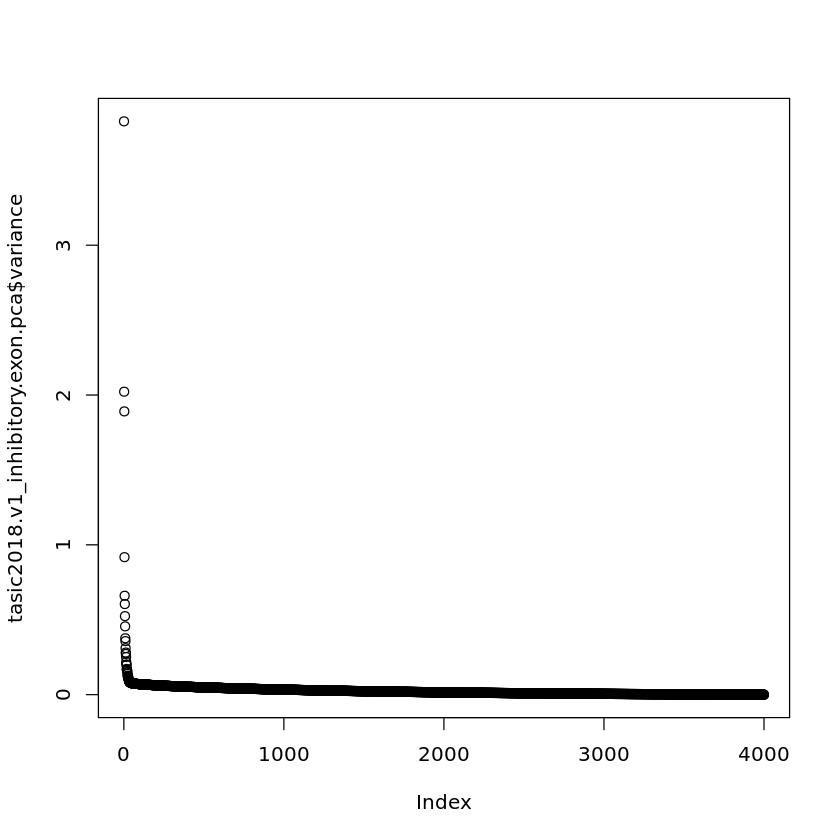

In [40]:
tasic2018.v1_inhibitory.exon.pca <- pca(tasic2018.v1_inhibitory.exon.counts.normed)
plot(tasic2018.v1_inhibitory.exon.pca$variance)

In [41]:
tPC1_fromTasic2018 <- data.frame(gene = colnames(tasic2018.v1_inhibitory.exon.counts.normed),
                                           tPC1 = tasic2018.v1_inhibitory.exon.pca$rotated$PC1) %>% arrange(tPC1)
head(tPC1_fromTasic2018)

,gene,tPC1
,<chr>,<dbl>
1,Lhx6,-54.96610
2,Sox6,-53.64161
3,Nxph1,-50.64836
4,Tmem44,-48.72819
5,Mafb,-46.94829
6,Nek7,-46.73281


In [42]:
tPC1_fromTasic2018.bugeongenesonly <- tPC1_fromTasic2018[tPC1_fromTasic2018$gene %in% bugeon2022.genes,]

print(dim(tPC1_fromTasic2018.bugeongenesonly  ))
tPC1_fromTasic2018.bugeongenesonly

[1] 56  2


,gene,tPC1
,<chr>,<dbl>
1,Lhx6,-54.9661022
8,Satb1,-44.9937914
11,Pvalb,-44.1578195
12,Crhbp,-43.8896200
42,Gabrd,-33.4854170
58,Tac1,-31.3567850
69,Calb1,-30.4076132
113,Rgs4,-26.4037109
116,Cort,-26.0674207


In [43]:
length(tPC1_fromTasic2018.bugeongenesonly$gene)
duplicated(tPC1_fromTasic2018.bugeongenesonly$gene)

[1] 56

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [44]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromTasic2018.bugeongenesonly$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022[tPC1.bugeon2022 %in% tPC1_fromTasic2018.bugeongenesonly$gene]){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromTasic2018.bugeongenesonly$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic <- rank.tPC1.from_rnaseq
tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromTasic2018.bugeongenesonly$gene <- as.factor(tPC1_fromTasic2018.bugeongenesonly$gene)
rownames(tPC1_fromTasic2018.bugeongenesonly)

[1] "1"    "8"    "11"   "12"   "42"   "58"   "69"   "113"  "116"  "137" 
[11] "148"  "252"  "354"  "525"  "679"  "718"  "1932" "1940" "1979" "2008"
[21] "2143" "2408" "2905" "2955" "3256" "3280" "3454" "3626" "3740" "3750"
[31] "3766" "3800" "3806" "3820" "3861" "3865" "3892" "3905" "3908" "3937"
[41] "3945" "3952" "3954" "3956" "3957" "3958" "3960" "3969" "3970" "3971"
[51] "3975" "3976" "3977" "3982" "3994" "3995"

In [45]:
head(tPC1_fromTasic2018.bugeongenesonly)

,gene,tPC1,rank_in_tasic,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
1,Lhx6,-54.96610,1,3
8,Satb1,-44.99379,2,1
11,Pvalb,-44.15782,3,10
12,Crhbp,-43.88962,4,6
42,Gabrd,-33.48542,5,21
58,Tac1,-31.35679,6,13


In [46]:
cor.test( tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic,  tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic and tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon
S = 3974, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8641832 


We can also compute it with just the Bugeon genes but it's better this way.

### Graded IEG expression along this axis.

In [47]:
iegs.tasic2018.tPC1_ranking <- tPC1_fromTasic2018[tPC1_fromTasic2018$gene %in% meta.iegs,]
iegs.tasic2018.tPC1_ranking

,gene,tPC1
,<chr>,<dbl>
265,Dusp1,-17.882861
595,Rgs2,-10.983625
643,Fbxo33,-10.364437
893,Ccdc184,-7.713809
967,Plagl1,-7.115024
1782,Tiparp,-2.170432
2492,Errfi1,1.616407
2807,Ppp1r15a,3.459686
3123,Gadd45g,5.589685


#### Tasic v1 Inihbitory Cells Activity (Sum of all metaIEGs after normalization, including ones not computed in PC)

In [48]:
# plotting IEG acitivy per cluster type
macthed.iegs <- rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered) %in% meta.iegs]
tasic2018v1_inhibitory.meta$iegsum_activity <- colSums(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[macthed.iegs ,])

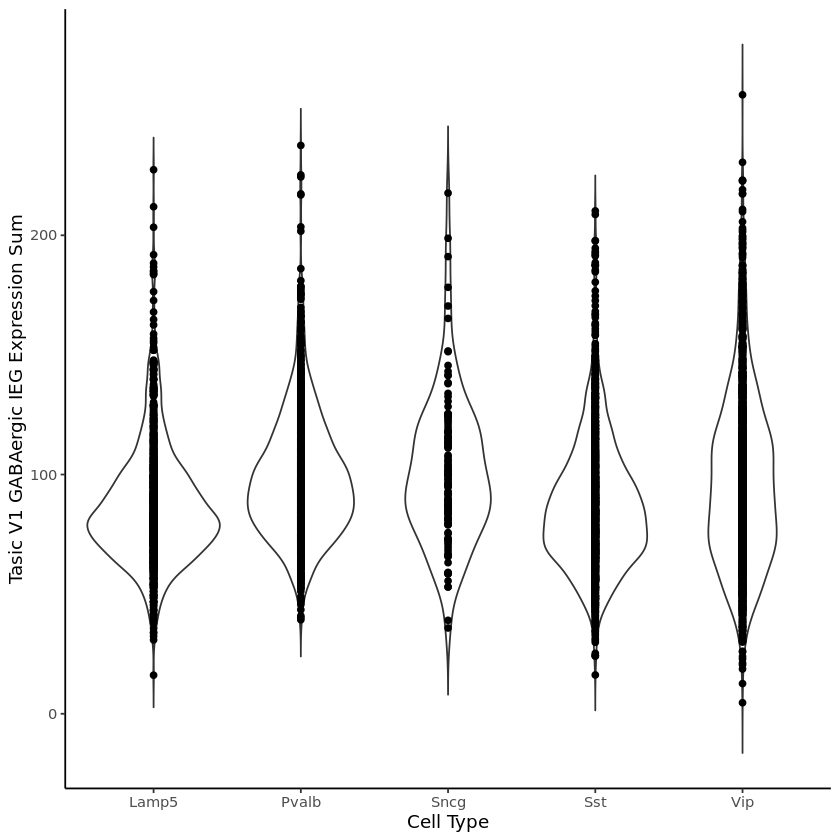

In [49]:
p <- tasic2018v1_inhibitory.meta %>% ggplot(aes(x=cell_subclass, y=iegsum_activity)) + 
  geom_violin(trim=FALSE) +
  geom_point()+
  xlab('Cell Type')+
  ylab('Tasic V1 GABAergic IEG Expression Sum')+
  theme_classic()
p


Heat map of cells activity. Cells organized by tPC1 loadings (rotation) and IEGs by PC1 scores.  Only iegs from the metaIEGl lsit in teh top 3k variable genes are included in the display, other gene were removed for computing PCA.

In [50]:
# adding this to meta to organize cells
tasic2018v1_inhibitory.meta$tPC1_score <- tasic2018.v1_inhibitory.exon.pca$loadings$PC1

# construct dataframe from this pc score
tPC1cell.idx.df <- tasic2018v1_inhibitory.meta %>% 
                   select(sample_name, tPC1_score, iegsum_activity, cell_class, cell_subclass, cell_cluster)  %>% 
                   arrange(tPC1_score)

tPC1cell.idx.df$cell_class <- as.factor(tPC1cell.idx.df$cell_class)
tPC1cell.idx.df$cell_subclass <- as.factor(tPC1cell.idx.df$cell_subclass)
tPC1cell.idx.df$cell_cluster <- as.factor(tPC1cell.idx.df$cell_cluster)

In [51]:
head(tPC1cell.idx.df)

,sample_name,tPC1_score,iegsum_activity,cell_class,cell_subclass,cell_cluster
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,F2S4_170406_007_G01,-0.02338807,95.04792,GABAergic,Pvalb,Pvalb Sema3e Kank4
2,F2S4_160401_004_B01,-0.02334360,92.89439,GABAergic,Pvalb,Pvalb Sema3e Kank4
3,F2S4_160411_001_C01,-0.02320444,124.97186,GABAergic,Pvalb,Pvalb Reln Tac1
4,F2S4_160805_005_D01,-0.02299522,118.16665,GABAergic,Pvalb,Pvalb Tpbg
5,F2S4_160401_003_A01,-0.02286787,101.88504,GABAergic,Pvalb,Pvalb Tpbg
6,F2S4_160804_003_D01,-0.02251171,114.77332,GABAergic,Pvalb,Pvalb Tpbg


In [52]:
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes <- tasic2018.v1_inhibitory.exon.counts.normed[tPC1cell.idx.df$sample_name,iegs.tasic2018.tPC1_ranking$gene]
print(iegs.tasic2018.tPC1_ranking$gene[1:5])
head(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes)

[1] "Dusp1"   "Rgs2"    "Fbxo33"  "Ccdc184" "Plagl1" 


,Dusp1,Rgs2,Fbxo33,Ccdc184,Plagl1,Tiparp,Errfi1,Ppp1r15a,Gadd45g,Coq10b,Junb,Egr1,Ier2,Fos,Crem,Fosl2,Nr4a1,Pcsk1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2S4_170406_007_G01,0.7696837,0.9571156,0.9403221,0.9939863,-0.6371489,0.8620288,0.41218238,-0.9067642,0.3181110,0.5583448,0.58350524,-0.9092159,0.2666682,-1.11469236,-1.056472412,-0.35580538,-0.7585514,-0.8912823
F2S4_160401_004_B01,1.2633179,0.7178379,0.9711746,1.1334673,1.0106266,-0.8037414,0.37411005,0.7338840,-0.1160878,0.2934469,-0.59717233,-0.9092159,0.6174268,0.30215864,-0.363756295,-0.37116520,-0.7585514,-0.8912823
F2S4_160411_001_C01,1.2797899,0.8939437,1.0742178,0.6825209,1.3931794,0.8061979,0.49868677,0.8190237,0.8098345,0.8015170,-0.10197530,-0.9092159,0.7438198,0.78039445,0.007275711,0.93616763,-0.7585514,-0.8912823
F2S4_160805_005_D01,1.1123955,0.8632052,0.8713575,1.1387463,1.2844918,0.7447691,0.26304152,0.8620667,0.5631017,0.1926031,-0.07328672,0.6139464,-0.1833814,0.41259399,-0.918516822,0.77366034,-0.7585514,0.7083587
F2S4_160401_003_A01,1.2876876,0.8780066,0.7019608,0.9029973,-0.6371489,1.3263620,-0.06273464,0.4974113,0.5250796,-0.2802041,0.44128406,0.3208287,0.4379642,-0.06233356,-0.230615678,-0.02591347,-0.7585514,-0.8912823
F2S4_160804_003_D01,1.3218216,0.8174926,0.3723664,1.4114680,0.8177670,1.2023808,0.69609745,0.8515343,0.9539101,0.1470712,1.03721727,-0.2955898,0.6102968,0.21622725,0.522705366,-0.85039115,1.0512810,-0.8912823


In [53]:
#tPC1cell.idx.df

#        annotation_row = my_sample_row)
#annot <- tPC1cell.idx.df %>% select(cell_subclass, cell_cluster)
annot <- tPC1cell.idx.df %>% select(cell_class, cell_subclass)
#annot <- as.data.frame(annot))
rownames(annot) <- tPC1cell.idx.df$sample_name

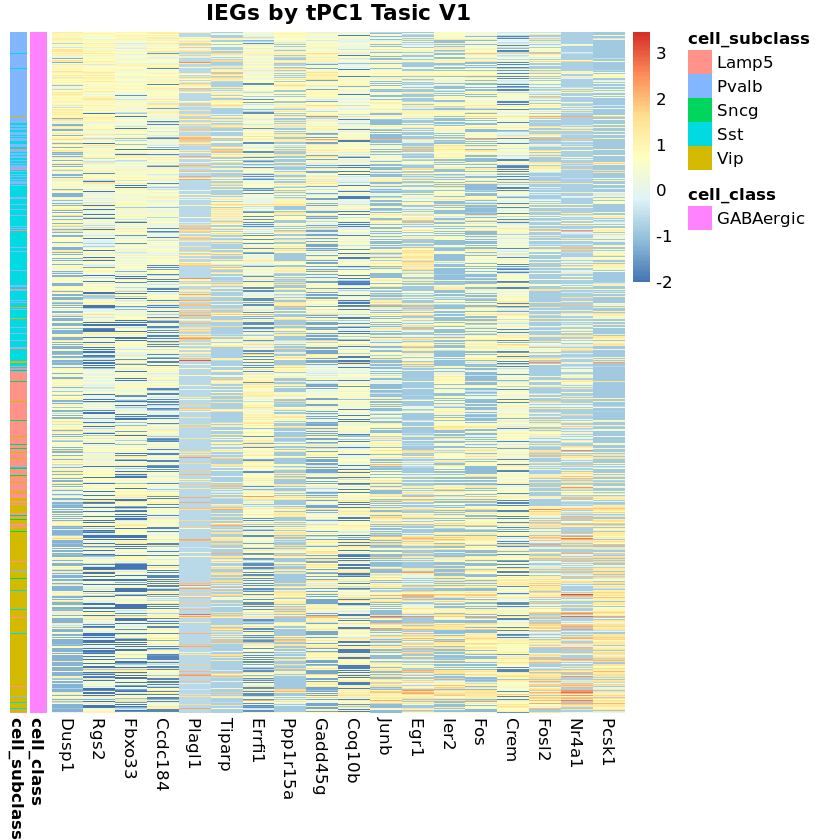

In [54]:
temp_hm <-pheatmap(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes,
                   cluster_rows = FALSE, cluster_cols = FALSE, show_rownames = F,
                   main = "IEGs by tPC1 Tasic V1",
                   annotation_row = annot)

In [55]:
# doing it with cell cluster means
tPC1cell.idx.df

sample_name,tPC1_score,iegsum_activity,cell_class,cell_subclass,cell_cluster
<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>
F2S4_170406_007_G01,-0.02338807,95.04792,GABAergic,Pvalb,Pvalb Sema3e Kank4
F2S4_160401_004_B01,-0.02334360,92.89439,GABAergic,Pvalb,Pvalb Sema3e Kank4
F2S4_160411_001_C01,-0.02320444,124.97186,GABAergic,Pvalb,Pvalb Reln Tac1
F2S4_160805_005_D01,-0.02299522,118.16665,GABAergic,Pvalb,Pvalb Tpbg
F2S4_160401_003_A01,-0.02286787,101.88504,GABAergic,Pvalb,Pvalb Tpbg
F2S4_160804_003_D01,-0.02251171,114.77332,GABAergic,Pvalb,Pvalb Tpbg
F2S4_160805_005_H01,-0.02247827,87.74503,GABAergic,Pvalb,Pvalb Tpbg
F2S4_160608_001_D01,-0.02245302,85.68685,GABAergic,Pvalb,Pvalb Sema3e Kank4
F2S4_170320_006_D01,-0.02240763,97.97800,GABAergic,Pvalb,Pvalb Reln Itm2a


In [56]:
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$Subtype <- tPC1cell.idx.df$cell_cluster
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$tPC1_score <- tPC1cell.idx.df$tPC1_score
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$iegsum_activity <- tPC1cell.idx.df$iegsum_activity

In [57]:
colnames(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes)

[1] "Dusp1"           "Rgs2"            "Fbxo33"          "Ccdc184"        
 [5] "Plagl1"          "Tiparp"          "Errfi1"          "Ppp1r15a"       
 [9] "Gadd45g"         "Coq10b"          "Junb"            "Egr1"           
[13] "Ier2"            "Fos"             "Crem"            "Fosl2"          
[17] "Nr4a1"           "Pcsk1"           "Subtype"         "tPC1_score"     
[21] "iegsum_activity"

In [321]:
head(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes)

,Dusp1,Rgs2,Fbxo33,Ccdc184,Plagl1,Tiparp,Errfi1,Ppp1r15a,Gadd45g,Coq10b,...,Egr1,Ier2,Fos,Crem,Fosl2,Nr4a1,Pcsk1,Subtype,tPC1_score,iegsum_activity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
F2S4_170406_007_G01,0.7696837,0.9571156,0.9403221,0.9939863,-0.6371489,0.8620288,0.41218238,-0.9067642,0.3181110,0.5583448,...,-0.9092159,0.2666682,-1.11469236,-1.056472412,-0.35580538,-0.7585514,-0.8912823,Pvalb Sema3e Kank4,-0.02338807,95.04792
F2S4_160401_004_B01,1.2633179,0.7178379,0.9711746,1.1334673,1.0106266,-0.8037414,0.37411005,0.7338840,-0.1160878,0.2934469,...,-0.9092159,0.6174268,0.30215864,-0.363756295,-0.37116520,-0.7585514,-0.8912823,Pvalb Sema3e Kank4,-0.02334360,92.89439
F2S4_160411_001_C01,1.2797899,0.8939437,1.0742178,0.6825209,1.3931794,0.8061979,0.49868677,0.8190237,0.8098345,0.8015170,...,-0.9092159,0.7438198,0.78039445,0.007275711,0.93616763,-0.7585514,-0.8912823,Pvalb Reln Tac1,-0.02320444,124.97186
F2S4_160805_005_D01,1.1123955,0.8632052,0.8713575,1.1387463,1.2844918,0.7447691,0.26304152,0.8620667,0.5631017,0.1926031,...,0.6139464,-0.1833814,0.41259399,-0.918516822,0.77366034,-0.7585514,0.7083587,Pvalb Tpbg,-0.02299522,118.16665
F2S4_160401_003_A01,1.2876876,0.8780066,0.7019608,0.9029973,-0.6371489,1.3263620,-0.06273464,0.4974113,0.5250796,-0.2802041,...,0.3208287,0.4379642,-0.06233356,-0.230615678,-0.02591347,-0.7585514,-0.8912823,Pvalb Tpbg,-0.02286787,101.88504
F2S4_160804_003_D01,1.3218216,0.8174926,0.3723664,1.4114680,0.8177670,1.2023808,0.69609745,0.8515343,0.9539101,0.1470712,...,-0.2955898,0.6102968,0.21622725,0.522705366,-0.85039115,1.0512810,-0.8912823,Pvalb Tpbg,-0.02251171,114.77332


In [58]:
iegsbytpc1.subtype_means.df <- iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes %>%
                               select(-Subtype) %>%
                               aggregate(list(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$Subtype), mean) %>%
                               arrange(tPC1_score) %>%
                               column_to_rownames(var ='Group.1')

In [59]:
head(iegsbytpc1.subtype_means.df)

,Dusp1,Rgs2,Fbxo33,Ccdc184,Plagl1,Tiparp,Errfi1,Ppp1r15a,Gadd45g,Coq10b,Junb,Egr1,Ier2,Fos,Crem,Fosl2,Nr4a1,Pcsk1,tPC1_score,iegsum_activity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pvalb Reln Itm2a,0.7805565,0.8161857,0.3435337,0.9917719,1.1317763,-0.08171025,0.01852479,0.11689678,0.18990671,-0.139709799,-0.10326998,-0.6275897,0.06127679,0.02804553,-1.10215991,-0.22984556,-0.5273000,-0.7640620,-0.01859927,91.10385
Pvalb Tpbg,0.7671531,0.7878046,0.5092302,0.5088286,0.2562754,0.72663611,0.25919945,0.26514268,0.67553334,0.276767929,0.27617671,0.3576513,0.24596454,0.54152678,-0.02986119,0.31832789,-0.3033207,-0.5327801,-0.01731527,111.44125
Pvalb Sema3e Kank4,0.4662238,0.6810023,0.5315553,0.6497598,-0.1138940,0.01133456,0.09187778,0.03641029,0.04613777,0.008625778,-0.52237595,-0.7620702,0.06484630,-0.56126296,-0.82690723,-0.40429013,-0.7291706,-0.8209835,-0.01716049,87.93852
Pvalb Gpr149 Islr,0.8671825,0.4689668,0.3256466,0.9354278,0.2143614,0.15171633,-0.07688256,0.23186647,0.44087480,0.027732927,0.05534812,-0.1452513,0.20477556,0.41671239,-0.16691163,-0.09436766,-0.2926746,-0.6428266,-0.01646599,101.66935
Pvalb Calb1 Sst,0.3393994,0.3738435,0.1981442,0.1010664,-0.1393432,-0.26766917,0.22354997,0.08234852,0.42481615,0.046513049,-0.25736149,-0.6397812,-0.04887502,-0.37387789,-0.16250957,-0.23674842,-0.5308195,-0.7123156,-0.01612382,85.77001
Pvalb Reln Tac1,0.7024928,0.6748992,0.2008147,0.4979065,0.5059622,-0.11283960,0.02720282,0.05464076,0.44761632,-0.220773037,-0.06231304,-0.5046651,0.12086854,-0.21711412,-0.46735951,-0.14268449,-0.4951048,-0.7208033,-0.01597730,91.47010


In [60]:
tPC1_mean.df <- data.frame( tPC1_meanscore = iegsbytpc1.subtype_means.df$tPC1_score,
                            iegsum_meanactivity = iegsbytpc1.subtype_means.df$iegsum_activity)
rownames(tPC1_mean.df) <- rownames(iegsbytpc1.subtype_means.df)
tPC1_mean.df$relative.scaled.means <- scale(tPC1_mean.df$tPC1_meanscore)
tPC1_mean.df$relative.scaled.iegsum_meanactivity  <- scale(tPC1_mean.df$iegsum_meanactivity)

In [61]:
subtype_to_type_annotation <- function(subtype_string, list_of_subtypes, list_of_types){
                                #checks the strings of subtypes to for begingin string
                                #to map to a type, ends loop if one is detected returns 
                                # what it was given, returns match if it finds something 
                                # and en empty string if there is no match
                                # includes a break stement to stop loop once match is found
                                # assumes list_of_subtypes and list_of_types are same length
                                # with corresponging entries
                                output.string <- ""
                                for(i in c(1:length(list_of_subtypes))){
                                if(startsWith(subtype_string, list_of_subtypes[i])){
                                   output.string <- list_of_types[i]
                                   break
                                    }# end of ifstatement
                                  }# end of for loop
                                return(output.string)
                                }# end of function

In [62]:
subclass.names <- unique(tasic2018v1_inhibitory.meta$cell_subclass)
subclass.names

[1] "Pvalb" "Vip"   "Lamp5" "Sst"   "Sncg"

In [63]:
tPC1_mean.df$subclass <- sapply(rownames(tPC1_mean.df), FUN = function(x) subtype_to_type_annotation(x, subclass.names, subclass.names) )

In [64]:
iegsbytpc1.subtype_means.df <- select(iegsbytpc1.subtype_means.df, -tPC1_score)
iegsbytpc1.subtype_means.df <- select(iegsbytpc1.subtype_means.df, -iegsum_activity)

In [65]:
head(tPC1_mean.df)

,tPC1_meanscore,iegsum_meanactivity,relative.scaled.means,relative.scaled.iegsum_meanactivity,subclass
,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<chr>
Pvalb Reln Itm2a,-0.01859927,91.10385,-1.515483,-0.1567791,Pvalb
Pvalb Tpbg,-0.01731527,111.44125,-1.408025,1.1391305,Pvalb
Pvalb Sema3e Kank4,-0.01716049,87.93852,-1.395072,-0.3584754,Pvalb
Pvalb Gpr149 Islr,-0.01646599,101.66935,-1.336950,0.5164600,Pvalb
Pvalb Calb1 Sst,-0.01612382,85.77001,-1.308313,-0.4966536,Pvalb
Pvalb Reln Tac1,-0.01597730,91.47010,-1.296052,-0.1334410,Pvalb


In [66]:
subclass.df <- data.frame('Subclass'=as.factor(tPC1_mean.df$subclass))
rownames(subclass.df) <- rownames(iegsbytpc1.subtype_means.df)

In [67]:
library(dichromat)

In [68]:
mycolors <- c('#4daf4a','#377eb8','#e41a1c','#984ea3','#ff7f00')
names(mycolors) <- unique(subclass.df$Subclass)
mycolors <- list(mycolors = mycolors)
mycolors

$mycolors
    Pvalb       Sst      Sncg     Lamp5       Vip 
"#4daf4a" "#377eb8" "#e41a1c" "#984ea3" "#ff7f00"

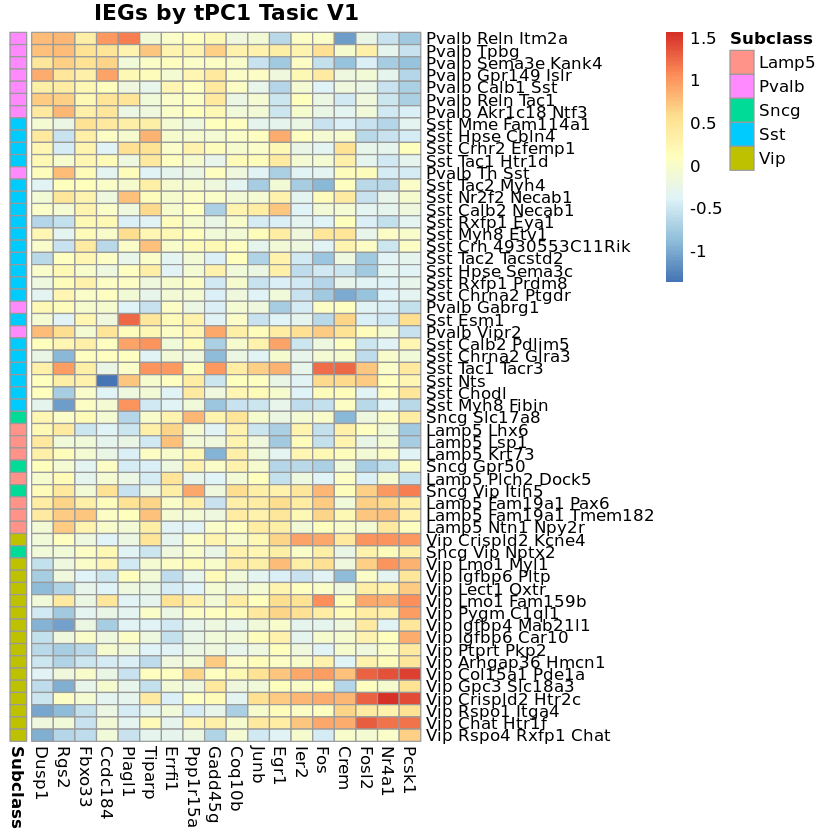

In [69]:
#annotation_colors = mycolors,

temp_hm <-pheatmap(iegsbytpc1.subtype_means.df,
                   cluster_rows = FALSE, cluster_cols = FALSE,
                   annotation_row = subclass.df,
                   main = "IEGs by tPC1 Tasic V1")

In [70]:
save_pheatmap(temp_hm, filename='Tasic_tPC1_V1_GABAergic_meanIEGexpression.png', width = 600, height=600)

png 
  2

In [168]:
head(ieg.df)

,variable,value
,<fct>,<dbl>
1,Fos,-0.01758633
2,Fos,-0.14181558
3,Fos,-0.06371003
4,Fos,-0.00458672
5,Fos,-0.05070948
6,Fos,-0.13507126


In [71]:
tasic2018v1_inhibitory.meta$scaled.tPC1_score <- scale(tasic2018v1_inhibitory.meta$tPC1_score)
tasic2018v1_inhibitory.meta$scaled.iegsum_activity <- scale(tasic2018v1_inhibitory.meta$iegsum_activity)

In [72]:
#we use the tPC1_mean.df to order the elvels in the way we want
# note we had to use the rev function to get the exact order we want
tasic2018v1_inhibitory.meta$cell_cluster <- factor(tasic2018v1_inhibitory.meta$cell_cluster, levels=rev(rownames(tPC1_mean.df)) )

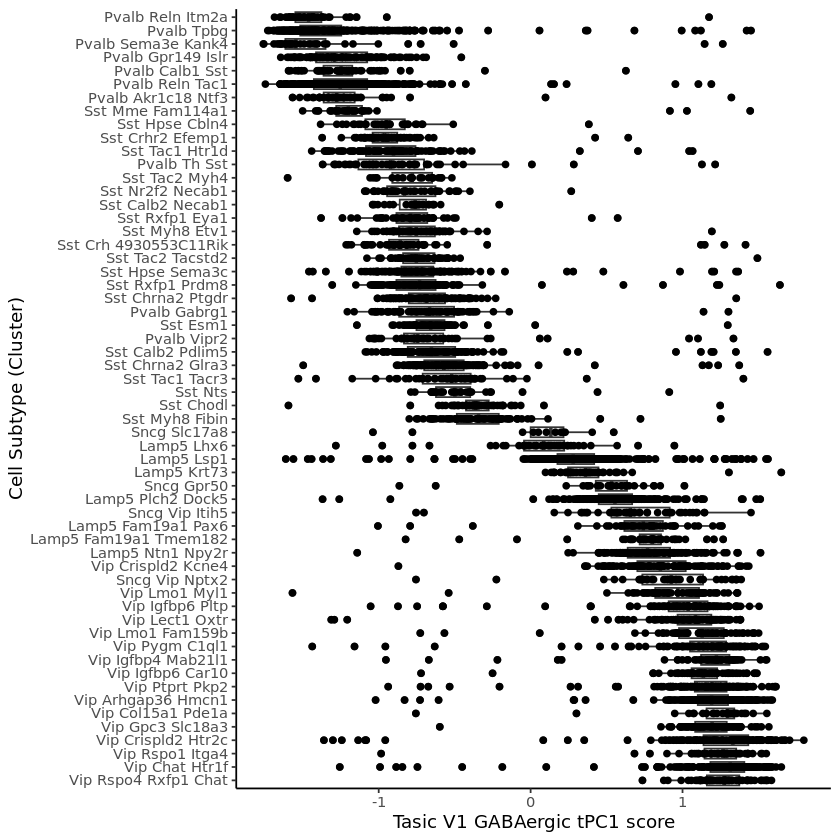

In [73]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=scaled.tPC1_score)) + 
     geom_boxplot() +
     geom_point()+
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Tasic V1 GABAergic tPC1 score')+
     theme_classic()
p

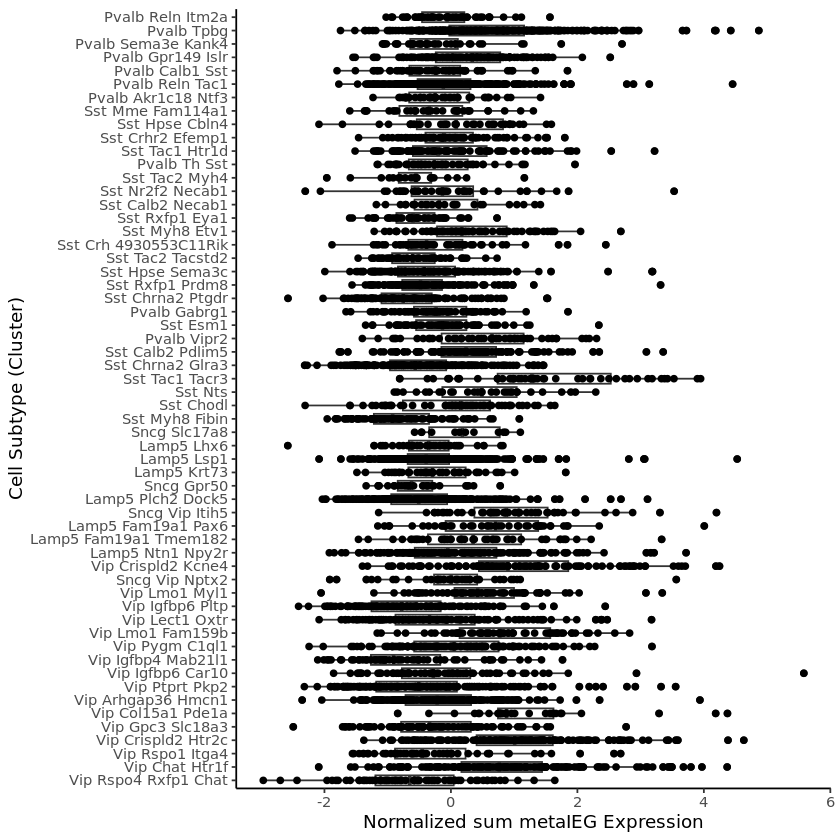

In [74]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=scaled.iegsum_activity)) + 
     geom_boxplot() +
     geom_point()+
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Normalized sum metaIEG Expression')+
     theme_classic()
p

In [75]:
# boot strap modulatiry scores for multiple genes
# compute the activity score for each cell type as a percentage
# of significant gradient genes, significantly modular genes and 
# genes that are both or niether

In [76]:
#p <- bp tPC1_mean.df$relative.scaled.means

###  Full gene set we calculate significant genes in data

In [77]:
library(tictoc)

In [78]:
# filter low expressed genes becuase they will not be removed 

# We first removed predicted gene models (gene names that start with Gm), genes from the mitochondrial chromosome, 
# ribosomal genes, sex-specific genes, as well as genes that were detected in fewer than four cells.

In [79]:
dim(tasic2018.v1_inhibitory.exon.counts)
dim(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)

[1] 45768  5663

[1] 18499  5663

In [80]:
# remove gene model genes, mitochondrial genes (Mt and Mrpl), and ribosomal protiens (Rpl)
filt.genes.idx <- !startsWith( rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered), 'Gm')
filt.genes.idx <- filt.genes.idx & !startsWith( rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered), 'Mt')
filt.genes.idx <- filt.genes.idx & !startsWith( rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered), 'Mrpl')
filt.genes.idx <- filt.genes.idx & !startsWith( rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered), 'Rpl') 

# still need to go to biomart and remove sex genes (genes from Y or X chromosome)

# remove genes expressed in less than 4 cells
filt.genes.idx <- filt.genes.idx & ( rowSums(tasic2018.v1_inhibitory.exon.counts[matched.protcoding.genes,]>0) > 4 )

# checks length of genes we can see ~3k are removed based on above criteria from Tasic
length(filt.genes.idx)
sum(filt.genes.idx)
filt.genes.idx[1:10]
names(filt.genes.idx)[filt.genes.idx==TRUE][1:10]

[1] 18499

[1] 15339

AA792892  Gm20816  Gm20817  Gm21094  Gm20870  Gm20903  Gm20738  Gm20850 
    TRUE    FALSE    FALSE    FALSE    FALSE    FALSE    FALSE    FALSE 
 Gm20867  Gm20795 
   FALSE    FALSE

[1] "AA792892" "Uba1y"    "Kdm5d"    "Eif2s3y"  "Uty"      "Ddx3y"   
 [7] "Usp9y"    "Sry"      "Chst9"    "Cdh2"

In [81]:
tasic2018.v1_inhibitory.exon.counts.normed.allgenes <-as.data.frame(scale(t(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[filt.genes.idx,])))
# after t() the data becomes a matrix and loses its colnames an rownames we need to get them from the og df but row ->cols and vice versa
genes <- rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[filt.genes.idx]
colnames(tasic2018.v1_inhibitory.exon.counts.normed.allgenes) <- genes #genes
rownames(tasic2018.v1_inhibitory.exon.counts.normed.allgenes) <- colnames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered) #cellids

In [82]:
dim(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)
dim(tasic2018.v1_inhibitory.exon.counts.normed.allgenes)

[1] 18499  5663

[1]  5663 15339

In [83]:
tic()
tasic2018.v1_inhibitory.prcomp.allgenes <- prcomp(tasic2018.v1_inhibitory.exon.counts.normed.allgenes, scale=FALSE)
tasic2018.v1_inhibitory.prcomp.allgenes <- pca_loading(tasic2018.v1_inhibitory.prcomp.allgenes) # computes laodings (correlation of genes with PC's) and their pvalues
toc()

101.688 sec elapsed


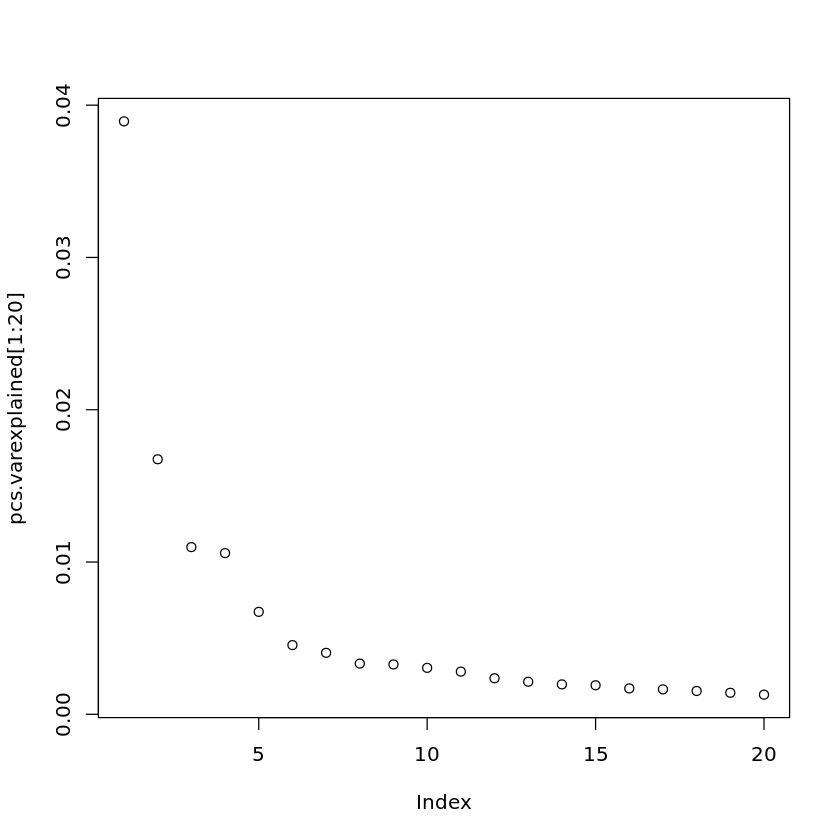

In [116]:
pcs.varexplained <- tasic2018.v1_inhibitory.prcomp.allgenes$sdev^2/sum(tasic2018.v1_inhibitory.prcomp.allgenes$sdev^2)
#pc.df <- data.frame( )
plot(pcs.varexplained[1:20])

[1] 3.89 1.67 1.10 1.06 0.67 0.45 0.40 0.33 0.33 0.30

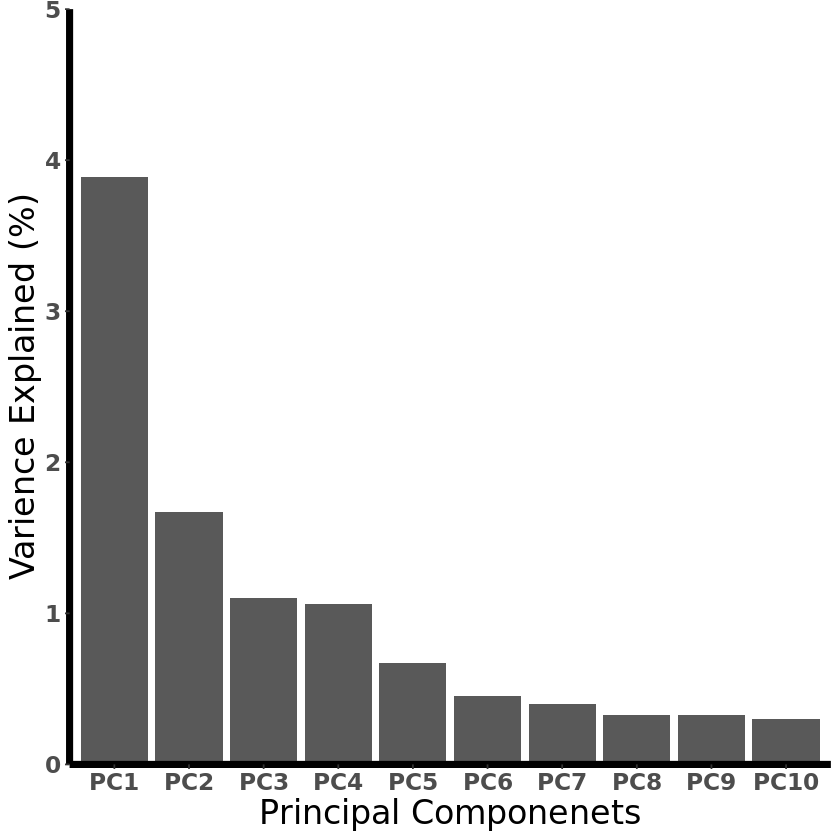

In [296]:
# varience explained plot
pc.df <- data.frame( PC = colnames(tasic2018.v1_inhibitory.prcomp.allgenes$x)[1:10],
    varience = pcs.varexplained[1:10]) %>% arrange(desc(varience))

pc.df$varience <- round(pc.df$varience*100, digits = 2)
pc.df$varience

#plotting
ggplot(data = pc.df, aes(x = reorder(PC, -varience), y = varience)) + 
geom_bar(stat ="identity") +
theme_classic() +
xlab('Principal Componenets') +
ylab('Varience Explained (%)' ) +
scale_y_continuous(expand = c(0, 0),limits=c(0, 5)) +
theme(axis.line=element_line(size=2)) + 
theme(axis.line=element_line(size=2),
     axis.title.x = element_text(size = 20),
      axis.title.y = element_text(size = 20),
     axis.text.x = element_text(size = 14, face = "bold"),
     axis.text.y = element_text(size = 14, face = "bold" ))

In [86]:
# lets adjust for multiple corrections within a PC
tPC1_gene_qvalues_BH <- p.adjust(tasic2018.v1_inhibitory.prcomp.allgenes$loading$p.value[,1], method='BH')
sum(tPC1_gene_qvalues_BH<0.01)

[1] 11756

In [87]:
# now we pull out the IEGs which are significantly correlated with tPC1
fdr.thresh <- 0.01

length(meta.iegs[meta.iegs %in% names(tPC1_gene_qvalues_BH)[tPC1_gene_qvalues_BH<fdr.thresh]])
meta.iegs.sig_on_tpc1 <- meta.iegs[meta.iegs %in% names(tPC1_gene_qvalues_BH)[tPC1_gene_qvalues_BH<fdr.thresh]]
print(meta.iegs.sig_on_tpc1)
tPC1_gene_qvalues_BH[names(tPC1_gene_qvalues_BH) %in% meta.iegs.sig_on_tpc1]

[1] 33

 [1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Dusp1"    "Egr1"     "Egr2"     "Egr3"     "Errfi1"   "Fbxo33"  
[13] "Fos"      "Fosb"     "Fosl2"    "Herpud1"  "Klf4"     "Mbnl2"   
[19] "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"    "Peg10"   
[25] "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"     "Rgs2"    
[31] "Sertad1"  "Sik1"     "Tiparp"  


Npas4           Fos          Egr1         Mbnl2          Egr2 
 1.462174e-10  4.633045e-12  1.076488e-12 6.138190e-151  9.880775e-10 
       Fbxo33          Egr3         Pcsk1           Arc          Crem 
1.176285e-155  2.497467e-13 3.233788e-147  2.891083e-03  2.426986e-13 
       Coq10b          Fosb         Dusp1         Nr4a1       Herpud1 
 2.393509e-22  3.182950e-37 4.341573e-229  1.491982e-79 1.713820e-130 
         Rem2        Plagl1          Atf3        Tiparp          Per1 
 5.510665e-03  7.735532e-43  7.004261e-11  3.437386e-36  1.239494e-09 
         Sik1       Ccdc184      Ppp1r15a          Klf4         Peg10 
 2.582972e-25 8.738741e-100  2.183354e-40  2.702382e-07  6.647384e-31 
         Rgs2         Nr4a3         Ptgs2         Fosl2        Errfi1 
 4.806347e-89  1.473351e-21  2.847238e-16  3.678541e-66  1.833610e-87 
         Btg2       Sertad1         Nr4a2 
 2.242514e-07  1.359392e-11  3.783882e-03

In [88]:
tPC1_fromTasic2018 <- data.frame(gene = colnames(tasic2018.v1_inhibitory.exon.counts.normed.allgenes),
                                           tPC1 = tasic2018.v1_inhibitory.prcomp.allgenes$loading$R[,1],
                                 p.value = tasic2018.v1_inhibitory.prcomp.allgenes$loading$p.value[,1],
                                q.value_BH = p.adjust(tasic2018.v1_inhibitory.prcomp.allgenes$loading$p.value[,1], method='BH')) %>% arrange(tPC1)
head(tPC1_fromTasic2018)

,gene,tPC1,p.value,q.value_BH
,<chr>,<dbl>,<dbl>,<dbl>
Ndrg4,Ndrg4,-0.7801180,0,0
Cplx1,Cplx1,-0.7245356,0,0
Nxph1,Nxph1,-0.6959728,0,0
Mpped1,Mpped1,-0.6732115,0,0
Ptprm,Ptprm,-0.6383517,0,0
Mafb,Mafb,-0.6359683,0,0


In [89]:
fdr.thresh <- 0.01
iegs.tasic2018.tPC1_ranking <- tPC1_fromTasic2018[(tPC1_fromTasic2018$q.value_BH<fdr.thresh)&(tPC1_fromTasic2018$gene %in% meta.iegs),]
dim(iegs.tasic2018.tPC1_ranking)
head(iegs.tasic2018.tPC1_ranking )

[1] 33  4

,gene,tPC1,p.value,q.value_BH
,<chr>,<dbl>,<dbl>,<dbl>
Dusp1,Dusp1,-0.4116883,1.318973e-230,4.341573e-229
Fbxo33,Fbxo33,-0.3436634,9.815792e-157,1.176285e-155
Mbnl2,Mbnl2,-0.3386690,5.486315e-152,6.138190e-151
Herpud1,Herpud1,-0.3158761,2.052473e-131,1.713820e-130
Ccdc184,Ccdc184,-0.2773330,1.584926e-100,8.738741e-100
Rgs2,Rgs2,-0.2622663,1.008020e-89,4.806347e-89


In [90]:
tasic2018v1_inhibitory.meta$tPC1_score <- tasic2018.v1_inhibitory.prcomp.allgenes$x[,1]

# construct dataframe from this pc score
tPC1cell.idx.df <- tasic2018v1_inhibitory.meta %>% 
                   select(sample_name, tPC1_score, iegsum_activity, cell_class, cell_subclass, cell_cluster)  %>% 
                   arrange(tPC1_score)

tPC1cell.idx.df$cell_class <- as.factor(tPC1cell.idx.df$cell_class)
tPC1cell.idx.df$cell_subclass <- as.factor(tPC1cell.idx.df$cell_subclass)
tPC1cell.idx.df$cell_cluster <- as.factor(tPC1cell.idx.df$cell_cluster)

In [91]:
dim(tPC1cell.idx.df)
head(tPC1cell.idx.df)

[1] 5663    6

,sample_name,tPC1_score,iegsum_activity,cell_class,cell_subclass,cell_cluster
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,F2S4_160615_012_C01,-51.48839,137.07110,GABAergic,Pvalb,Pvalb Gpr149 Islr
2,F2S4_160727_003_C01,-51.41270,65.76577,GABAergic,Sst,Sst Mme Fam114a1
3,F2S4_160408_001_D01,-51.35207,95.46536,GABAergic,Pvalb,Pvalb Tpbg
4,F2S4_160805_001_H01,-50.84535,95.07551,GABAergic,Pvalb,Pvalb Reln Itm2a
5,F2S4_160805_003_A01,-50.79482,113.40854,GABAergic,Pvalb,Pvalb Tpbg
6,F2S4_160401_003_A01,-50.73737,101.88504,GABAergic,Pvalb,Pvalb Tpbg


In [92]:
head(tasic2018.v1_inhibitory.exon.counts.normed)

,Kdm5d,Eif2s3y,Uty,Ddx3y,Cep120,Csnk1g3,Aldh7a1,C330018D20Rik,Trappc8,Rnf138,...,Dolpp1,Crat,Vps16,Lmo2,Coq4,Slc27a4,Zfp120,Syndig1,Apmap,Entpd6
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2S4_151217_005_B01,1.0669681,1.0411360,1.57633316,0.1567552,-0.05054542,0.5505251,-1.2329694,-0.7566109,-1.3675295,-1.3559592,...,1.0040220,1.6871815,0.45329899,-0.9732243,0.7610998,0.5337574,-0.6857759,0.8297746,0.6323812,-0.02846040
F2S4_151217_006_B01,-0.8606309,0.7833338,-0.92036592,-1.2410544,0.75604464,1.1031369,1.0530696,-0.7566109,-0.8139281,0.8743886,...,-1.0948573,-0.9263244,-1.15669659,-0.9732243,-1.1872409,0.9895053,-0.6857759,-0.9765136,-1.8171445,0.71002422
F2S4_151217_006_H01,-0.8606309,0.1107931,0.62262410,1.0159445,-1.37437798,-0.4461352,-0.5800442,1.3944331,0.9221675,0.5492963,...,-1.0948573,1.2776606,0.68837394,1.4091582,1.0233511,0.9866362,1.6596073,-0.5864332,0.1491847,0.05765658
F2S4_151217_009_B01,-0.8606309,0.6405280,0.90303800,0.1561382,-0.24336614,0.7017096,-1.2329694,-0.7566109,0.4238233,0.6129979,...,0.1247583,-0.9263244,0.03957428,-0.9732243,1.3796927,1.2197472,2.1965589,1.3992156,0.6778416,-1.50673290
F2S4_151217_009_C01,1.6987775,0.9252487,0.01608832,-0.1215194,-1.37437798,1.3808314,-1.2329694,1.8816921,1.3907484,1.3380990,...,-1.0948573,0.1113325,-1.46860043,1.0717415,1.4108700,-1.3672811,-0.6857759,-0.9765136,0.7102127,1.02827266
F2S4_151217_009_E01,-0.8606309,1.0501401,0.44695028,0.5363567,0.04447192,-1.4941049,-1.2329694,-0.7566109,0.7812084,-1.3559592,...,1.2760478,-0.9263244,1.02091230,-0.9732243,-1.1872409,-1.3672811,-0.6857759,-0.9765136,0.2635918,1.61562890


In [93]:
iegsbytpc1.tasicv1gabaergic.normed.scaled <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes[tPC1cell.idx.df$sample_name, iegs.tasic2018.tPC1_ranking$gene]
print(iegs.tasic2018.tPC1_ranking$gene[1:5])
head(iegsbytpc1.tasicv1gabaergic.normed.scaled)

[1] "Dusp1"   "Fbxo33"  "Mbnl2"   "Herpud1" "Ccdc184"


,Dusp1,Fbxo33,Mbnl2,Herpud1,Ccdc184,Rgs2,Errfi1,Plagl1,Ppp1r15a,Tiparp,...,Egr1,Egr3,Crem,Nr4a3,Sik1,Peg10,Fosb,Fosl2,Nr4a1,Pcsk1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2S4_160615_012_C01,1.0800766,0.6067931,0.3522090,0.1984483,1.5944992,0.1263916,0.42116833,1.5026765,0.24396906,1.3028431,...,0.6813926,1.7740469,-0.2093615,-0.4966867,1.5208016,-0.5715595,-0.4448753,0.77635305,0.1667562,-0.8912823
F2S4_160727_003_C01,-1.2128804,0.7958389,0.6605265,-0.1176464,0.4554072,-0.2951369,0.40871534,-0.6371489,-0.08757559,1.3813021,...,-0.9092159,-0.3175742,-1.4768302,-0.4966867,-0.5705127,-0.5715595,-0.4448753,-0.85039115,-0.7585514,-0.8912823
F2S4_160408_001_D01,0.9074592,0.8573012,0.6259985,0.4390800,1.0738664,0.3003288,-0.55796643,1.3349468,0.77397536,1.1632058,...,-0.9092159,-0.3175742,-1.2477448,-0.4966867,-0.5705127,0.3240117,-0.4448753,-0.85039115,-0.7585514,-0.8912823
F2S4_160805_001_H01,0.5156814,1.0169420,1.0094431,0.3426560,1.2275733,0.7649581,0.81011822,1.3741381,0.92591294,0.6303379,...,-0.9092159,-0.3175742,-1.7822367,-0.4966867,-0.5705127,-0.5715595,-0.4448753,0.10147416,-0.7585514,-0.8912823
F2S4_160805_003_A01,0.9399982,0.9504820,0.7640484,0.5789794,1.0104599,0.2320407,0.78060480,-0.6371489,0.96931181,1.4358479,...,0.2124101,-0.3175742,0.0606237,-0.4966867,-0.5705127,-0.5715595,-0.4448753,0.74895804,-0.4924066,0.3826337
F2S4_160401_003_A01,1.2876876,0.7019608,0.2714697,0.4527974,0.9029973,0.8780066,-0.06273464,-0.6371489,0.49741132,1.3263620,...,0.3208287,-0.3175742,-0.2306157,0.1956993,-0.5705127,-0.5715595,-0.4448753,-0.02591347,-0.7585514,-0.8912823


In [94]:
iegsbytpc1.tasicv1gabaergic.normed.scaled$Subtype <- tPC1cell.idx.df$cell_cluster
iegsbytpc1.tasicv1gabaergic.normed.scaled$tPC1_score <- tPC1cell.idx.df$tPC1_score
iegsbytpc1.tasicv1gabaergic.normed.scaled$iegsum_activity <- tPC1cell.idx.df$iegsum_activity

In [95]:
iegsbytpc1.subtype_means.df <- iegsbytpc1.tasicv1gabaergic.normed.scaled %>%
                               select(-Subtype) %>%
                               aggregate(list(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$Subtype), mean) %>%
                               arrange(tPC1_score) %>%
                               column_to_rownames(var ='Group.1')

In [96]:
colnames(iegsbytpc1.subtype_means.df)

[1] "Dusp1"           "Fbxo33"          "Mbnl2"           "Herpud1"        
 [5] "Ccdc184"         "Rgs2"            "Errfi1"          "Plagl1"         
 [9] "Ppp1r15a"        "Tiparp"          "Coq10b"          "Ptgs2"          
[13] "Sertad1"         "Egr2"            "Per1"            "Arc"            
[17] "Rem2"            "Nr4a2"           "Klf4"            "Btg2"           
[21] "Npas4"           "Atf3"            "Fos"             "Egr1"           
[25] "Egr3"            "Crem"            "Nr4a3"           "Sik1"           
[29] "Peg10"           "Fosb"            "Fosl2"           "Nr4a1"          
[33] "Pcsk1"           "tPC1_score"      "iegsum_activity"

In [97]:
subtype_to_type_annotation <- function(subtype_string, list_of_subtypes, list_of_types){
                                #checks the strings of subtypes to for begingin string
                                #to map to a type, ends loop if one is detected returns 
                                # what it was given, returns match if it finds something 
                                # and en empty string if there is no match
                                # includes a break stement to stop loop once match is found
                                # assumes list_of_subtypes and list_of_types are same length
                                # with corresponging entries
                                output.string <- ""
                                for(i in c(1:length(list_of_subtypes))){
                                if(startsWith(subtype_string, list_of_subtypes[i])){
                                   output.string <- list_of_types[i]
                                   break
                                    }# end of ifstatement
                                  }# end of for loop
                                return(output.string)
                                }# end of function

In [98]:
subclass.names <- unique(tasic2018v1_inhibitory.meta$cell_subclass)
subclass.names

[1] "Pvalb" "Vip"   "Lamp5" "Sst"   "Sncg"

In [99]:
tPC1_mean.df$subclass <- sapply(rownames(tPC1_mean.df), 
                                FUN = function(x) subtype_to_type_annotation(x, subclass.names, subclass.names) )

In [100]:
iegsbytpc1.subtype_means.df <- select(iegsbytpc1.subtype_means.df, -tPC1_score)
iegsbytpc1.subtype_means.df <- select(iegsbytpc1.subtype_means.df, -iegsum_activity)

In [101]:
head(tPC1_mean.df)

,tPC1_meanscore,iegsum_meanactivity,relative.scaled.means,relative.scaled.iegsum_meanactivity,subclass
,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<chr>
Pvalb Reln Itm2a,-0.01859927,91.10385,-1.515483,-0.1567791,Pvalb
Pvalb Tpbg,-0.01731527,111.44125,-1.408025,1.1391305,Pvalb
Pvalb Sema3e Kank4,-0.01716049,87.93852,-1.395072,-0.3584754,Pvalb
Pvalb Gpr149 Islr,-0.01646599,101.66935,-1.336950,0.5164600,Pvalb
Pvalb Calb1 Sst,-0.01612382,85.77001,-1.308313,-0.4966536,Pvalb
Pvalb Reln Tac1,-0.01597730,91.47010,-1.296052,-0.1334410,Pvalb


In [102]:
subclass.df <- data.frame('Subclass'=as.factor(tPC1_mean.df$subclass))
rownames(subclass.df) <- rownames(iegsbytpc1.subtype_means.df)

In [103]:
library(dichromat)

In [104]:
mycolors <- c('#4daf4a','#377eb8','#e41a1c','#984ea3','#ff7f00')
names(mycolors) <- unique(subclass.df$Subclass)
mycolors <- list(mycolors = mycolors)
mycolors

$mycolors
    Pvalb       Sst      Sncg     Lamp5       Vip 
"#4daf4a" "#377eb8" "#e41a1c" "#984ea3" "#ff7f00"

In [105]:
#annotation_colors = mycolors,

In [161]:
subclass.df

,Subclass
,<fct>
Pvalb Reln Itm2a,Pvalb
Pvalb Sema3e Kank4,Pvalb
Pvalb Tpbg,Pvalb
Pvalb Gpr149 Islr,Pvalb
Pvalb Reln Tac1,Pvalb
Pvalb Calb1 Sst,Pvalb
Pvalb Akr1c18 Ntf3,Pvalb
Sst Mme Fam114a1,Sst
Sst Crhr2 Efemp1,Sst


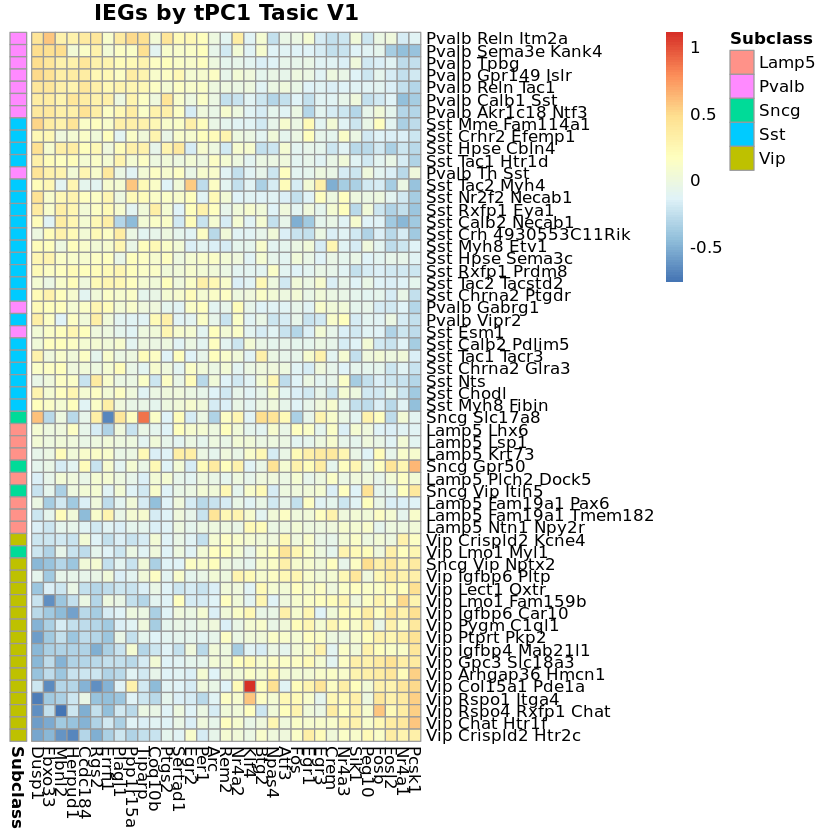

In [160]:
temp_hm <-pheatmap(iegsbytpc1.subtype_means.df,
                   cluster_rows = FALSE, cluster_cols = FALSE,
                   annotation_row = subclass.df,
                   main = "IEGs by tPC1 Tasic V1")

In [106]:
save_pheatmap(temp_hm, filename='Tasic_tPC1_V1_GABAergic_meanIEGexpression_allgenes.png', width = 600, height=600)

png 
  2

In [309]:

head(mouse_tfs.df)

,Species,Symbol,Ensembl,Family,Protein,Entrez ID
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,Mus_musculus,Zfp146,ENSMUSG00000037029,zf-C2H2,ENSMUSP00000058588;,26465
3,Mus_musculus,Ets1,ENSMUSG00000032035,ETS,ENSMUSP00000051303;ENSMUSP00000139107;ENSMUSP00000034534;,23871
4,Mus_musculus,Mxd3,ENSMUSG00000021485,bHLH,ENSMUSP00000021941;,17121
5,Mus_musculus,Rhox6,ENSMUSG00000097200,Homeobox,ENSMUSP00000138055;,-
6,Mus_musculus,Zfp82,ENSMUSG00000098022,zf-C2H2,ENSMUSP00000079647;ENSMUSP00000138217;,330502
7,Mus_musculus,Lef1,ENSMUSG00000027985,HMG,ENSMUSP00000067808;ENSMUSP00000101948;ENSMUSP00000029611;ENSMUSP00000096211;,16842


In [310]:
meta.iegs[meta.iegs %in% mouse_tfs.df$Symbol]

[1] "Atf3"   "Crem"   "Csrnp1" "Egr1"   "Egr2"   "Egr3"   "Fos"    "Fosb"  
 [9] "Fosl2"  "Gmeb2"  "Junb"   "Klf4"   "Npas4"  "Nr4a1"  "Nr4a2"  "Nr4a3" 
[17] "Plagl1"

It's worth noting that some of these metaIEGs are themselves transcription factors.  All of the Nr4a family, Plagl1, the Erg family, Jun, Npas4. Plagl1 is the 7th most higly loaded tPC1 metaIEG for the Pvalb axis, while the Crem, Nr4a1 & 3, Erg1 & 3, and Atf3 are all loaded with the Vip side of the gradient.  Seeing as these genes are known to be activity regulated it implies they are regulating specific activity related gene transcription.  it is interesting to note the Vip side is more heavily loaded with the IEGs which are TFs as Vip interneurons are known to have more specific tuning than otehr inhibitory interneurons and are thought to mediate the development of task selective stimuli.  Would be interesting to have included the Cck positive interneurons here.

In [214]:
colnames(tasic2018.v1_inhibitory.exon.counts.normed.allgenes)

[1] "AA792892"       "Uba1y"          "Kdm5d"          "Eif2s3y"       
    [5] "Uty"            "Ddx3y"          "Usp9y"          "Sry"           
    [9] "Chst9"          "Cdh2"           "Cep120"         "Csnk1g3"       
   [13] "Dsc3"           "Zfp608"         "Gramd3"         "Dsc2"          
   [17] "Dsc1"           "Dsg1a"          "Dsg1b"          "Aldh7a1"       
   [21] "Phax"           "Tex43"          "Lmnb1"          "C330018D20Rik" 
   [25] "Dsg2"           "Ttr"            "B4galt6"        "Megf10"        
   [29] "Trappc8"        "Rnf125"         "Rnf138"         "Mep1b"         
   [33] "Fbn2"           "Klhl14"         "Isoc1"          "Adamts19"      
   [37] "Ccdc178"        "Ifitm7"         "Klf9"           "Krtap7-1"      
   [41] "Krtap11-1"      "Rbm14"          "Rabl3"          "Hgd"           
   [45] "Chsy3"          "Ndufb4"         "Ccs"            "Marf1"         
   [49] "F830016B08Rik"  "Asxl3"          "Ccdc87"         "Iigp1"         
   [53] "Ctsf"           "Fstl1"          "Smim3"          "Dctn4"         
   [57] "Lrrc58"         "Gpr156"         "Gsk3b"          "Actn3"         
   [61] "Nol4"           "Nde1"           "Smc5"           "Rbm22"         
   [65] "Tiam1"          "Myoz3"          "Synpo"          "Zdhhc24"       
   [69] "Ndst1"          "Mamdc2"         "Rps14"          "Ptar1"         
   [73] "Bbs1"           "Dtna"           "Sod1"           "Scaf4"         
   [77] "Apba1"          "Dpp3"           "Hunk"           "Mis18a"        
   [81] "Cd74"           "Mrap"           "Urb1"           "Tjp2"          
   [85] "Mapre2"         "Myh11"          "Zfp397"         "Zfp35"         
   [89] "Peli3"          "Ino80c"         "Fxn"            "Tcof1"         
   [93] "Npas4"          "Pip5k1b"        "Fam122a"        "Tmem252"       
   [97] "Pgm5"           "Arsi"           "Galnt1"         "Foxd4"         
  [101] "Nrap"           "Eva1c"          "Gpr50"          "Trib2"         
  [105] "Slc16a2"        "2700062C07Rik"  "Heatr5a"        "Rprd1a"        
  [109] "Slc39a6"        "Vma21"          "Igsf11"         "Camk2a"        
  [113] "Cntnap3"        "Htr2c"          "Lsamp"          "Dtd2"          
  [117] "Rlim"           "Fam169a"        "Gap43"          "Efcab1"        
  [121] "Slc6a7"         "Prrg3"          "Syndig1l"       "Nsa2"          
  [125] "Nubpl"          "Elp2"           "Synj1"          "Fate1"         
  [129] "Slc29a2"        "Npc2"           "Isca2"          "Tfap2a"        
  [133] "Arhgap5"        "Cnga2"          "B4gat1"         "Abcb7"         
  [137] "Mocos"          "Cbwd1"          "Akap6"          "Pspc1"         
  [141] "Pdgfrb"         "Ube2v2"         "Nlrp4f"         "Casp7"         
  [145] "Uprt"           "Npas3"          "Gabre"          "Dach1"         
  [149] "Brms1"          "Mcm4"           "Gcnt2"          "Egln3"         
  [153] "Dock8"          "Zdhhc15"        "Sptssa"         "Csf1r"         
  [157] "Paxbp1"         "Ltbp2"          "Zfp369"         "Magee2"        
  [161] "Zmym5"          "Gabra3"         "Nme8"           "Agrp"          
  [165] "Rin1"           "Mzt1"           "Hmgxb3"         "Wdhd1"         
  [169] "4932438H23Rik"  "Cd248"          "Zbtb20"         "Tmem151a"      
  [173] "Kank1"          "Smug1"          "Pak1ip1"        "Gabrq"         
  [177] "Ctcf"           "Ccdc134"        "Slc26a2"        "Eapp"          
  [181] "Fhod3"          "Nr3c2"          "Dmrt2"          "Tmem14c"       
  [185] "Yif1a"          "Cetn2"          "Gpr141"         "Ppp2r5c"       
  [189] "Socs4"          "Elmo1"          "Lrch2"          "Zmym2"         
  [193] "Nhlrc2"         "Adrb1"          "Cbx5"           "Cnih2"         
  [197] "Bora"           "Pcm1"           "Ccdc186"        "C7"            
  [201] "Tigit"          "Prkdc"          "Card6"          "Aoah"          
  [205] "Prkaa1"         "Rab1b"          "Mapk1ip1l"      "Pbdc1"         
  [209] "Dis3"           "Srebf2"         "Klc2"    

In [255]:
tasic2018v1_inhibitory.meta$Fos <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Fos
tasic2018v1_inhibitory.meta$Arc <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Arc
tasic2018v1_inhibitory.meta$Npas4 <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Npas4
tasic2018v1_inhibitory.meta$Dusp1 <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Dusp1
tasic2018v1_inhibitory.meta$Fosb <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Fosb
tasic2018v1_inhibitory.meta$Nr4a1 <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Nr4a1
tasic2018v1_inhibitory.meta$Igf1 <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Igf1
#tasic2018v1_inhibitory.meta$Erg1 <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Erg1
# erg1 does not survive thresholding
tasic2018v1_inhibitory.meta$Gpd1 <- tasic2018.v1_inhibitory.exon.counts.normed.allgenes$Gpd1

In [292]:
write.csv(tasic2018v1_inhibitory.meta, '/home/acampbell/PavLabEngrams/IEG_gradients/V1_images/tasic2018v1_inhibitory_meta.csv')

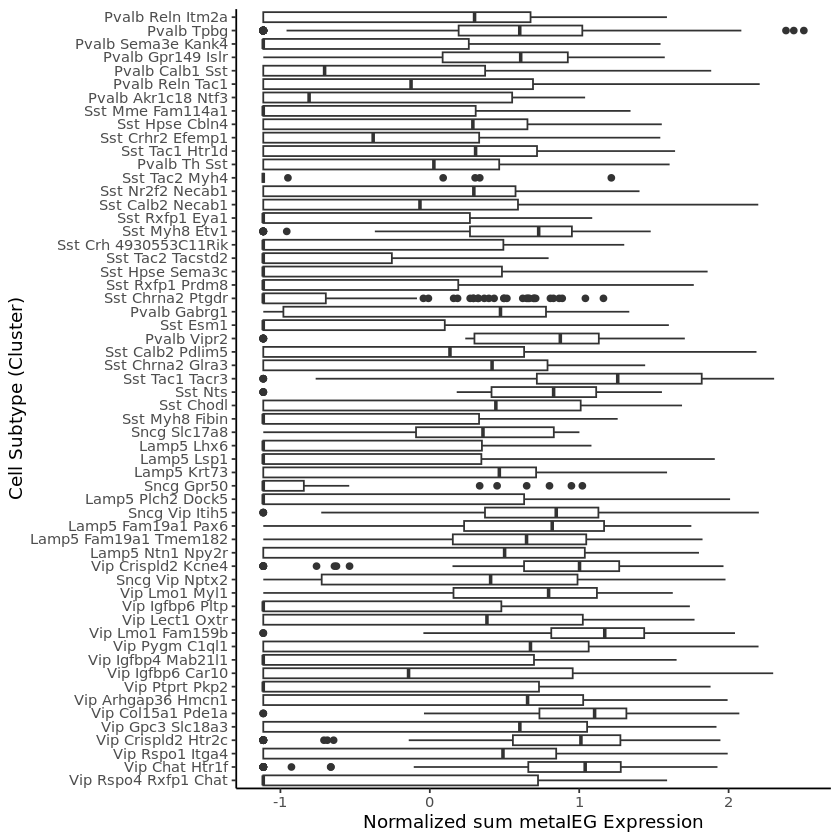

In [236]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=Fos)) + 
     geom_boxplot() +
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Normalized sum metaIEG Expression')+
     theme_classic()
p

Either fos is biasing results or thesew represent mor active cell states of the the cells.  Can't be determined by this data.

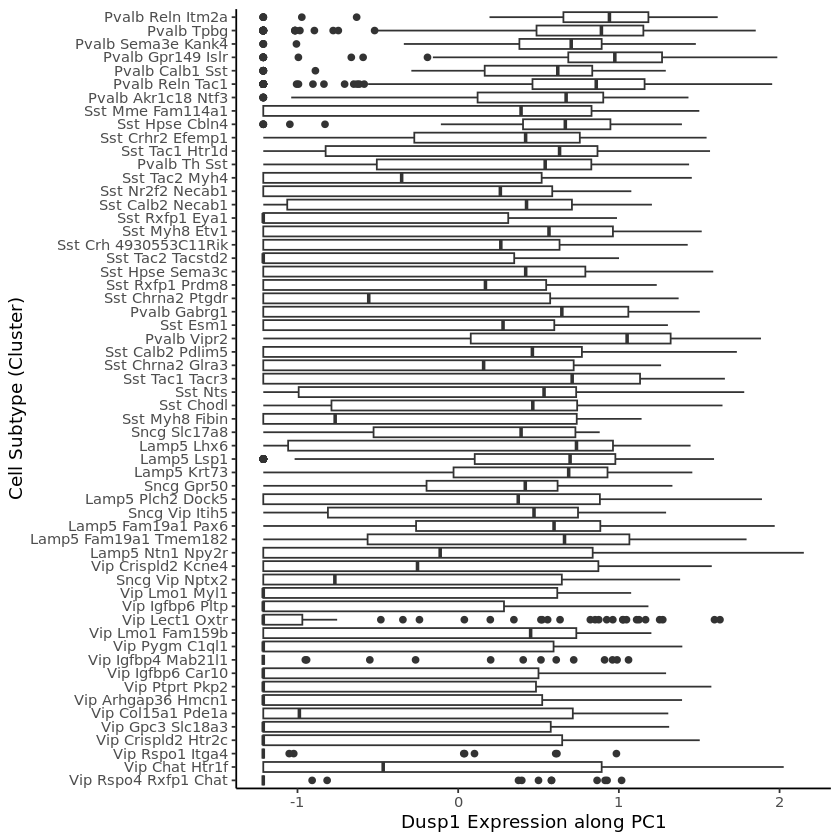

In [259]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=Dusp1)) + 
     geom_boxplot() +
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Dusp1 Expression along PC1')+
     theme_classic()
p

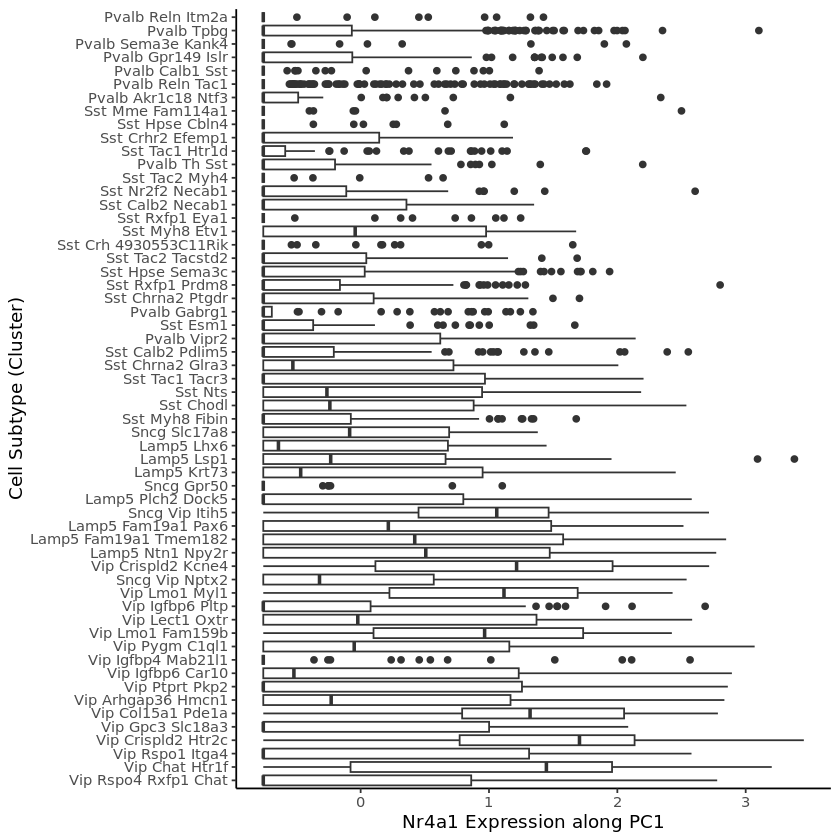

In [257]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y= Nr4a1)) + 
     geom_boxplot() +
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Nr4a1 Expression along PC1')+
     theme_classic()
p

In [280]:
install_version("ggridges", "0.5.0")

colorspace (2.0-3 -> 2.1-0) [CRAN]
rlang      (1.0.6 -> 1.1.0) [CRAN]
cli        (3.4.1 -> 3.6.0) [CRAN]
utf8       (1.2.2 -> 1.2.3) [CRAN]
vctrs      (0.5.1 -> 0.6.0) [CRAN]
fansi      (1.0.3 -> 1.0.4) [CRAN]
tibble     (3.1.8 -> 3.2.1) [CRAN]
isoband    (0.2.6 -> 0.2.7) [CRAN]
gtable     (0.3.1 -> 0.3.2) [CRAN]
plyr       (1.8.7 -> 1.8.8) [CRAN]
ggplot2    (3.4.0 -> 3.4.1) [CRAN]


Installing 11 packages: colorspace, rlang, cli, utf8, vctrs, fansi, tibble, isoband, gtable, plyr, ggplot2

Warning message in i.p(...):
"installation of package 'cli' had non-zero exit status"
Warning message in i.p(...):
"installation of package 'vctrs' had non-zero exit status"
Warning message in i.p(...):
"installation of package 'tibble' had non-zero exit status"
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [293]:
levels(tasic2018v1_inhibitory.meta$cell_cluster)

[1] "Vip Rspo4 Rxfp1 Chat"  "Vip Chat Htr1f"        "Vip Rspo1 Itga4"      
 [4] "Vip Crispld2 Htr2c"    "Vip Gpc3 Slc18a3"      "Vip Col15a1 Pde1a"    
 [7] "Vip Arhgap36 Hmcn1"    "Vip Ptprt Pkp2"        "Vip Igfbp6 Car10"     
[10] "Vip Igfbp4 Mab21l1"    "Vip Pygm C1ql1"        "Vip Lmo1 Fam159b"     
[13] "Vip Lect1 Oxtr"        "Vip Igfbp6 Pltp"       "Vip Lmo1 Myl1"        
[16] "Sncg Vip Nptx2"        "Vip Crispld2 Kcne4"    "Lamp5 Ntn1 Npy2r"     
[19] "Lamp5 Fam19a1 Tmem182" "Lamp5 Fam19a1 Pax6"    "Sncg Vip Itih5"       
[22] "Lamp5 Plch2 Dock5"     "Sncg Gpr50"            "Lamp5 Krt73"          
[25] "Lamp5 Lsp1"            "Lamp5 Lhx6"            "Sncg Slc17a8"         
[28] "Sst Myh8 Fibin"        "Sst Chodl"             "Sst Nts"              
[31] "Sst Tac1 Tacr3"        "Sst Chrna2 Glra3"      "Sst Calb2 Pdlim5"     
[34] "Pvalb Vipr2"           "Sst Esm1"              "Pvalb Gabrg1"         
[37] "Sst Chrna2 Ptgdr"      "Sst Rxfp1 Prdm8"       "Sst Hpse Sema3c"      
[40] "Sst Tac2 Tacstd2"      "Sst Crh 4930553C11Rik" "Sst Myh8 Etv1"        
[43] "Sst Rxfp1 Eya1"        "Sst Calb2 Necab1"      "Sst Nr2f2 Necab1"     
[46] "Sst Tac2 Myh4"         "Pvalb Th Sst"          "Sst Tac1 Htr1d"       
[49] "Sst Crhr2 Efemp1"      "Sst Hpse Cbln4"        "Sst Mme Fam114a1"     
[52] "Pvalb Akr1c18 Ntf3"    "Pvalb Reln Tac1"       "Pvalb Calb1 Sst"      
[55] "Pvalb Gpr149 Islr"     "Pvalb Sema3e Kank4"    "Pvalb Tpbg"           
[58] "Pvalb Reln Itm2a"

In [281]:
#https://cran.r-project.org/web/packages/ggridges/vignettes/introduction.html
library(ggridges)

In [284]:
p <-ggplot(tasic2018v1_inhibitory.meta, aes(x=Igf1, y= cell_cluster)) +
  geom_density_ridges() +
     ylab('Cell Subtype (Cluster)')+
     xlab('Igf1 Expression along PC1')
p

Warning message in eval(expr, envir, enclos):
"restarting interrupted promise evaluation"


ERROR: Error in eval(expr, envir, enclos): read failed on /home/acampbell/miniconda3/envs/pavlab-engrams/lib/R/library/ggridges/R/ggridges.rdb


In [267]:
install.pacakges("")

In [267]:
p <-ggplot(tasic2018v1_inhibitory.meta, aes(x=Igf1, y= cell_cluster, fill = stat(x))) +
  geom_density_ridges_gradient(scale = 3, rel_min_height = 0.01) +
  scale_fill_viridis_c(name = "UMI LogNorm Scaled", option = "C") +
     ylab('Cell Subtype (Cluster)')+
     xlab('Igf1 Expression along PC1')
p

Warning message in eval(expr, envir, enclos):
"restarting interrupted promise evaluation"


ERROR: Error in eval(expr, envir, enclos): read failed on /home/acampbell/miniconda3/envs/pavlab-engrams/lib/R/library/ggridges/R/ggridges.rdb


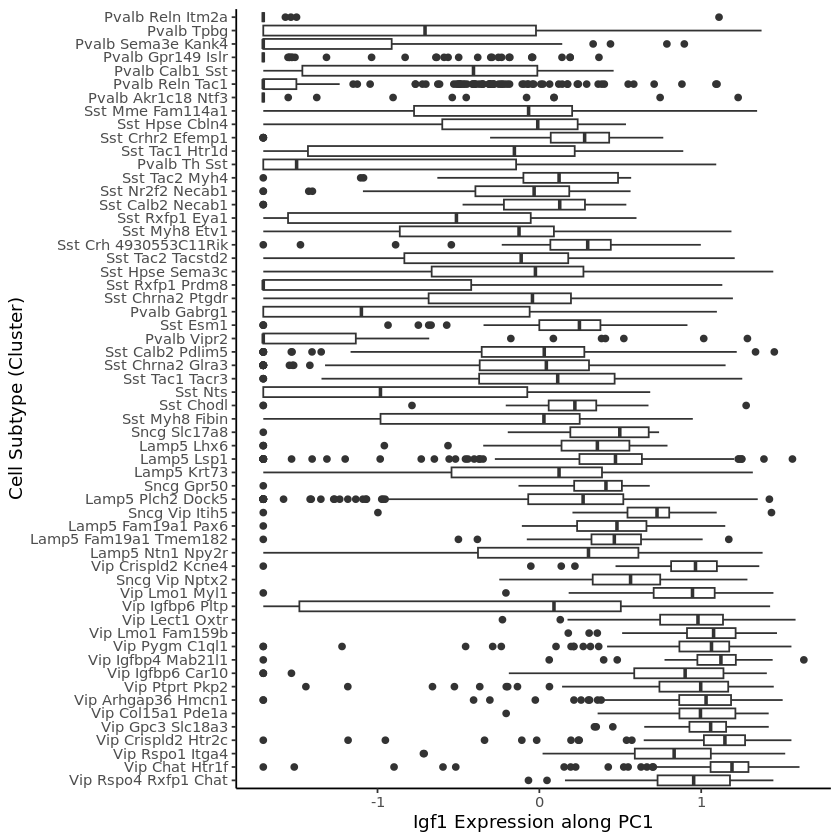

In [269]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=Igf1)) + 
     geom_boxplot() +
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Igf1 Expression along PC1')+
     theme_classic()
p

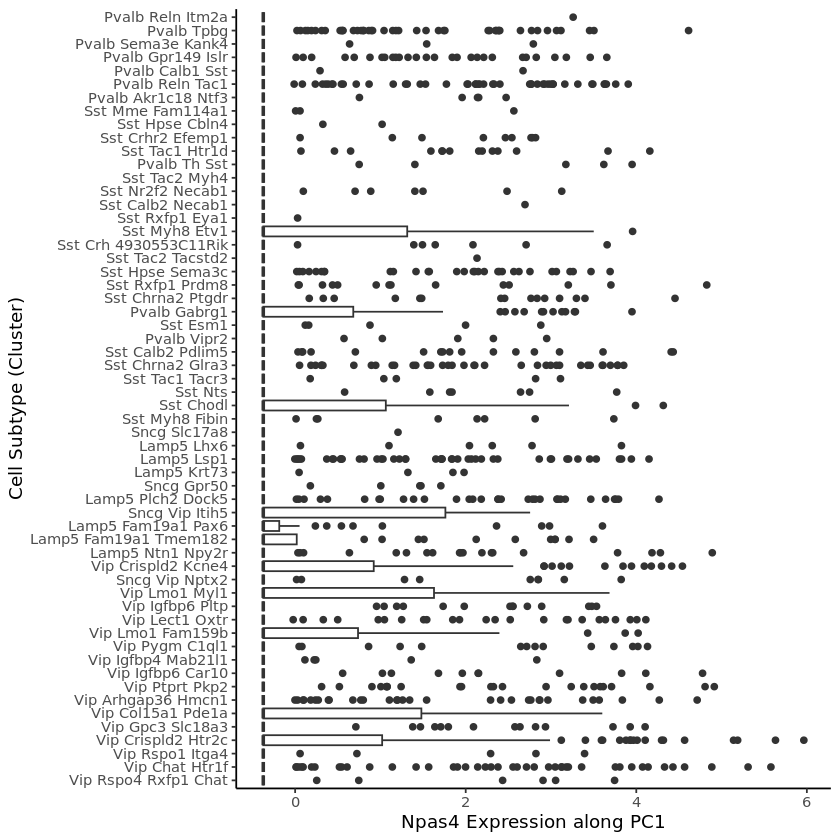

In [261]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=Npas4)) + 
     geom_boxplot() +
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Npas4 Expression along PC1')+
     theme_classic()
p

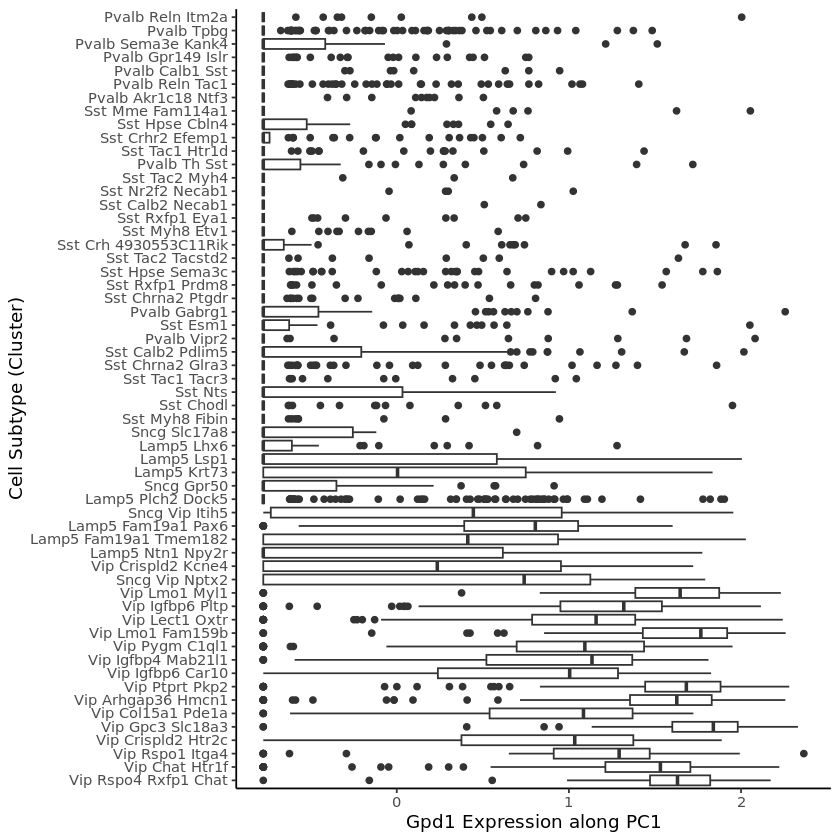

In [262]:
p <- tasic2018v1_inhibitory.meta %>%  
     ggplot(aes(x=cell_cluster, y=Gpd1)) + 
     geom_boxplot() +
     coord_flip()+
     xlab('Cell Subtype (Cluster)')+
     ylab('Gpd1 Expression along PC1')+
     theme_classic()
p

Note though that Pvalb cells are basket cells which are known to be much more active.  Igf1 is confirmed to be induced by acitivty in Vip cells.  It may be interesting to just look at raw reads, what constitutes a 1 fold change relative to the mean across all cells is somewhat confusing.

In [209]:
iegs.df <- as.data.frame(scale(t(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[meta.iegs,])))
rownames(iegs.df) <- colnames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)
colnames(iegs.df) <- meta.iegs
iegs.df$Subtype <- as.factor(tasic2018v1_inhibitory.meta$cell_cluster, levels = rownames(iegsbytpc1.subtype_means.df))

ERROR: Error in as.factor(tasic2018v1_inhibitory.meta$cell_cluster, levels = rownames(iegsbytpc1.subtype_means.df)): unused argument (levels = rownames(iegsbytpc1.subtype_means.df))


It's clear that cell types occupy preferential places on the gradient, so at one end are the Pvalb cells and the Vip cells at the other, but the cell types get intermixed more to the middle of the gradient and interiguingly .  One can choose different cell subtypes within the same subtype and find differences in certain IEG expression, for instance we can take 

Lamp5 subtypes are all fairly lowly loaded on the gradient and so do not seem to have much intra-celltype differences.

## FUTURE directions for Next week

a) compute modularity score from smith et al the hippocampus NT paper the figure is stored in https://www.frontiersin.org/articles/10.3389/fncir.2022.836930/full
Smith, S. J., & von Zastrow, M. (2022). A molecular landscape of mouse hippocampal neuromodulation. Frontiers in Neural Circuits, 35.
b) compute bootstrap by shuffling cell type labels and calculating modularity scores 1000 times to bootstrap a null for that dataset
c) Note:  check cell type depths if you can, note that Vip cells express Penk as well it's a marker in bugeon and that if the Vip cells with penk are
higher in the cortical layers they could be recieving more top-down input
d) do this in the gowens patch seq dataset then look for cells within each subtype which are in the 90th percentile of IEG expression,
find specific patch clamp features which correlate with the active cells in those data

In [107]:

modularity_score_delta_smith2021 <- function(gene.mean.column){
n = length(gene.mean.column)
mu_max = max(gene.mean.column)
delta <- n-sum()/n-1}




modularity_score_delta_smith2021 <- function(df.gene.expression.subtypemeans){
# this functionc alculates the modularity index for a gene-subtype 
# defined in smith et al., 2021 a survyey of hippocampal NT receptore expression
    # here input is a dataframe cell subtype by 

    #df[] <- Map(pseudocount_log2p1_transform, df, scale_factor = scaleby, UMI.provided = UMI)
    }

### PCA full compoenent significance testing by boostrapping

In [108]:
#write.csv('tasci2018_V1_gaba_protcodinggenes_normed.csv',tasic2018.v1_inhibitory.exon.counts.normed.unfiltered, row.names=FALSE)

In [109]:
# it's scaling the data which is causing bugs
tic()
#pca.allgenes.test <- PCAtest(tasic2018.v1_inhibitory.exon.counts.normed.allgenes, 
#                                                   100, 100, 0.05, varcorr=FALSE, counter=FALSE, plot=TRUE)
toc()


Sampling bootstrap replicates... Please wait


ERROR: Error in prcomp.default(bootdata, scale = T, center = T): cannot rescale a constant/zero column to unit variance


In [ ]:
which(colSums(tasic2018.v1_inhibitory.exon.counts.normed.allgenes)==0)

In [ ]:
sum(rowSums(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[filt.genes.idx,])==0)

In [ ]:
rowSums(tasic2018.v1_inhibitory.exon.counts[c('Ptger3','Tnfsf15'),])

In [ ]:
rowSums(tasic2018.v1_inhibitory.exon.counts[c('Ptger3','Tnfsf15'),]>10)

In [ ]:
rowMeans(tasic2018.v1_inhibitory.exon.counts[c('Ptger3','Tnfsf15'),])

In [ ]:
rowMedians(tasic2018.v1_inhibitory.exon.counts[c('Ptger3','Tnfsf15'),])

In [ ]:
head(tasic2018.v1_inhibitory.exon.counts[c('Ptger3','Tnfsf15'),])

### Tasic again with just the bugeon genes

In [312]:
# can be pulled from the OG coutns datasets we just need to re run the scaling or whatever
bugeon2022.genes.idx <- colnames(tasic2018.v1_inhibitory.exon.counts.normed)  %in% bugeon2022.genes
sum(bugeon2022.genes.idx)

[1] 56

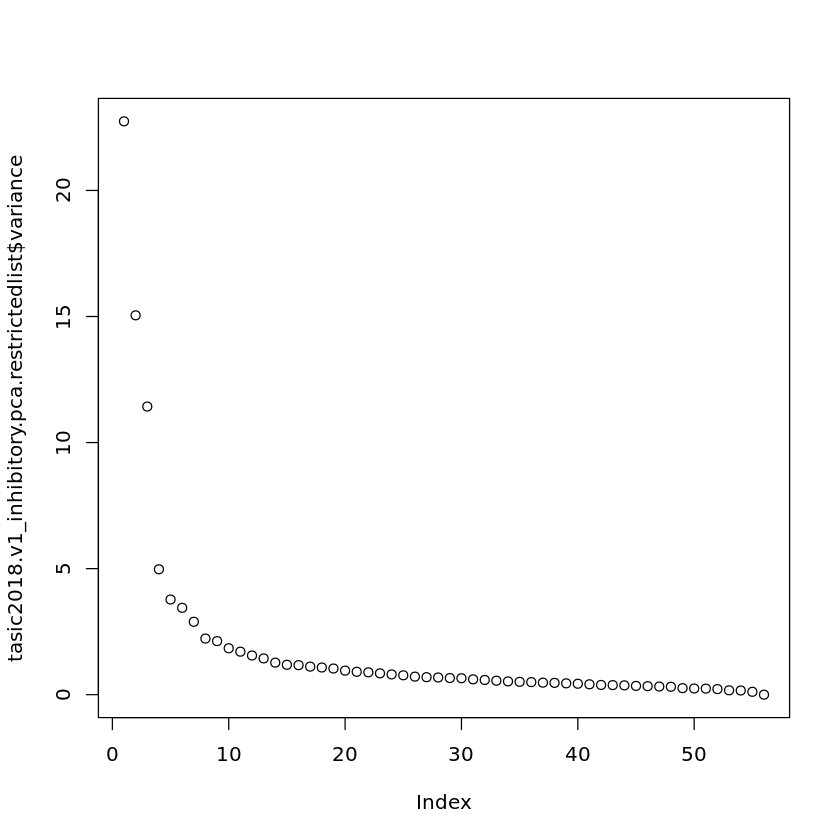

In [313]:
tasic2018.v1_inhibitory.pca.restrictedlist <- pca(tasic2018.v1_inhibitory.exon.counts.normed[,bugeon2022.genes.idx])
plot(tasic2018.v1_inhibitory.pca.restrictedlist$variance)

In [314]:
tasic2018.v1_inhibitory.pca.restrictedlist$variance

PC1          PC2          PC3          PC4          PC5          PC6 
2.274152e+01 1.504652e+01 1.142841e+01 4.974233e+00 3.773887e+00 3.445178e+00 
         PC7          PC8          PC9         PC10         PC11         PC12 
2.890480e+00 2.226168e+00 2.123670e+00 1.840660e+00 1.705461e+00 1.554112e+00 
        PC13         PC14         PC15         PC16         PC17         PC18 
1.438380e+00 1.271183e+00 1.185706e+00 1.171148e+00 1.112551e+00 1.077494e+00 
        PC19         PC20         PC21         PC22         PC23         PC24 
1.036773e+00 9.533366e-01 9.075804e-01 8.860446e-01 8.461705e-01 8.030872e-01 
        PC25         PC26         PC27         PC28         PC29         PC30 
7.681523e-01 7.163177e-01 6.941070e-01 6.820125e-01 6.592126e-01 6.512551e-01 
        PC31         PC32         PC33         PC34         PC35         PC36 
6.075894e-01 5.829441e-01 5.552672e-01 5.263400e-01 5.096569e-01 4.980786e-01 
        PC37         PC38         PC39         PC40         PC41         PC42 
4.769827e-01 4.682067e-01 4.494262e-01 4.334541e-01 4.115669e-01 3.859055e-01 
        PC43         PC44         PC45         PC46         PC47         PC48 
3.792592e-01 3.692220e-01 3.473342e-01 3.368835e-01 3.235402e-01 3.125886e-01 
        PC49         PC50         PC51         PC52         PC53         PC54 
2.585513e-01 2.448156e-01 2.404252e-01 2.203289e-01 1.729748e-01 1.639887e-01 
        PC55         PC56 
1.138613e-01 4.484973e-30

In [315]:
# varience explained plot
pc.df.bugeongenesonly <- data.frame( PC = names(tasic2018.v1_inhibitory.pca.restrictedlist$variance)[1:10],
    varience = tasic2018.v1_inhibitory.pca.restrictedlist$variance[1:10]) %>% arrange(desc(varience))

pc.df.bugeongenesonly$varience <- round(pc.df.bugeongenesonly$varience, digits = 2)
pc.df.bugeongenesonly$varience

[1] 22.74 15.05 11.43  4.97  3.77  3.45  2.89  2.23  2.12  1.84

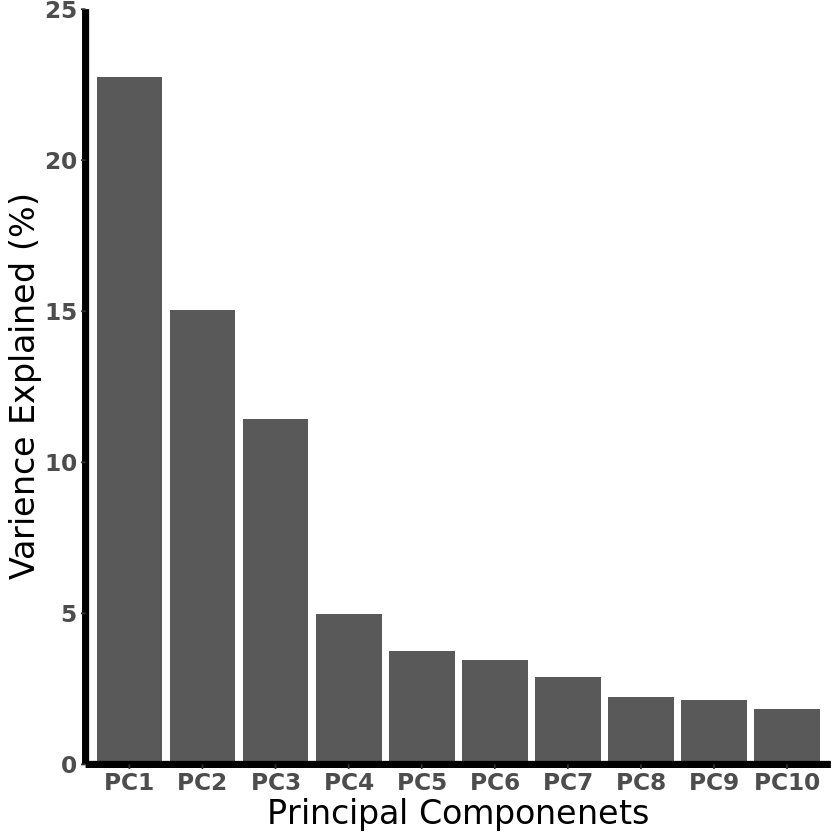

In [317]:
#plotting
ggplot(data = pc.df.bugeongenesonly, aes(x = reorder(PC, -varience), y = varience)) + 
geom_bar(stat ="identity") +
theme_classic() +
xlab('Principal Componenets') +
ylab('Varience Explained (%)' ) +
scale_y_continuous(expand = c(0, 0),limits=c(0, 25)) +
theme(axis.line=element_line(size=2)) + 
theme(axis.line=element_line(size=2),
     axis.title.x = element_text(size = 20),
      axis.title.y = element_text(size = 20),
     axis.text.x = element_text(size = 14, face = "bold"),
     axis.text.y = element_text(size = 14, face = "bold" ))

In [ ]:
tPC1_fromTasic2018.bugeongenesonly <- data.frame(gene = bugeon2022.genes,
                                           tPC1 = tasic2018.v1_inhibitory.pca.restrictedlist$rotated$PC1) %>% arrange(tPC1)
    
print(dim(tPC1_fromTasic2018.bugeongenesonly  ))
tPC1_fromTasic2018.bugeongenesonly

In [ ]:
# I would like to point out Rgs4 is also an IEG, shows up as important in active dentate gyrus cells as well

In [ ]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromTasic2018.bugeongenesonly$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromTasic2018.bugeongenesonly$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic <- rank.tPC1.from_rnaseq
tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromTasic2018.bugeongenesonly$gene <- as.factor(tPC1_fromTasic2018.bugeongenesonly$gene)
rownames(tPC1_fromrnaseq.bugeongenes)

In [ ]:
head(tPC1_fromTasic2018.bugeongenesonly)

In [ ]:
cor.test( tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic,  tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)

In [ ]:
# plot cells average acitivity score across the clusters, show some are more active
# plot the individual cells IEG expression vs their rank along the gradient
#, rank the IEGs by their position on tPC1, consider restricting to protien coding genes
# plot the clusters averag IEG expression again IEGs ordered by their position on PC1 and clusters ordered by their cells average
# position on PC1 posibly just using the bugeon genes

In [ ]:
# run the PCA's

In [110]:
saunders2018_dgc_counts.filt <- read.csv('/space/scratch/Saunders2018_Hp_GSE116470/saunders2018_dgc_counts_filt.csv')

In [113]:
saunders2018_dgc_counts.normscaled <- pavlab.normalize(saunders2018_dgc_counts.filt, median.scale = TRUE)

saunders2018_dgc_counts.normscaled <- as.data.frame(scale(t(saunders2018_dgc_counts.normscaled)))
rownames(saunders2018_dgc_counts.normscaled) <- colnames(saunders2018_dgc_counts.filt)
colnames(saunders2018_dgc_counts.normscaled) <- rownames(saunders2018_dgc_counts.filt)

ERROR: Error in sum(x): invalid 'type' (character) of argument


In [111]:
tic()
sauders.dgc.pca <- prcomp(saunders2018_dgc_counts.normscaled)
toc()

In [285]:
# run this is another script igrpah masks many packages
library(igraph)


Attaching package: 'igraph'


The following object is masked from 'package:ICtest':

    components


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    as_data_frame


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [286]:
tree <- make_tree(20, 3)

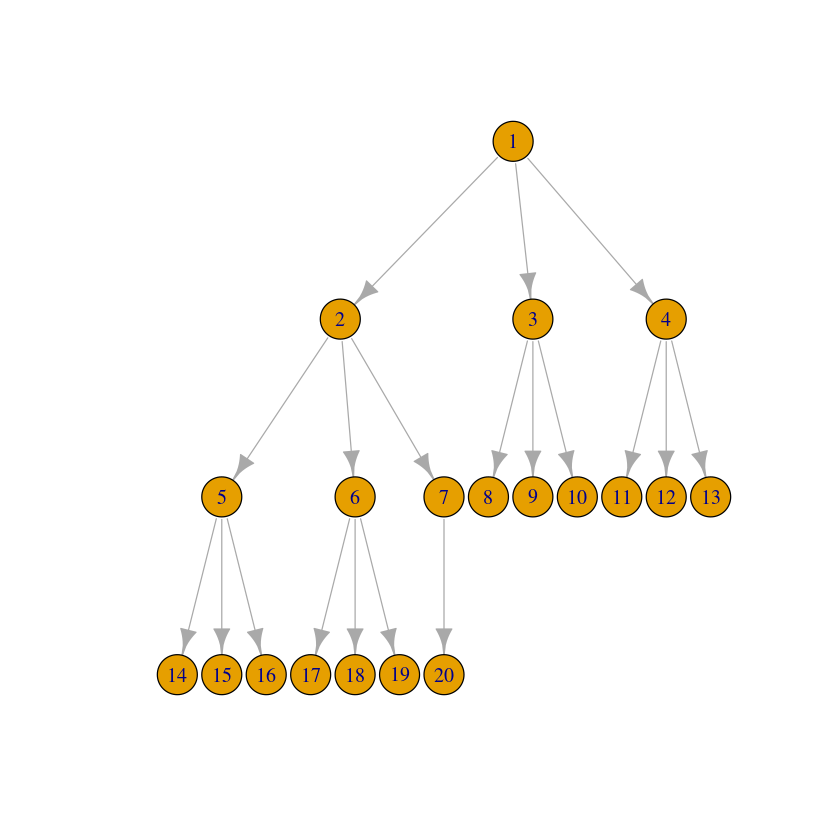

In [287]:
plot(tree, layout=layout_as_tree)

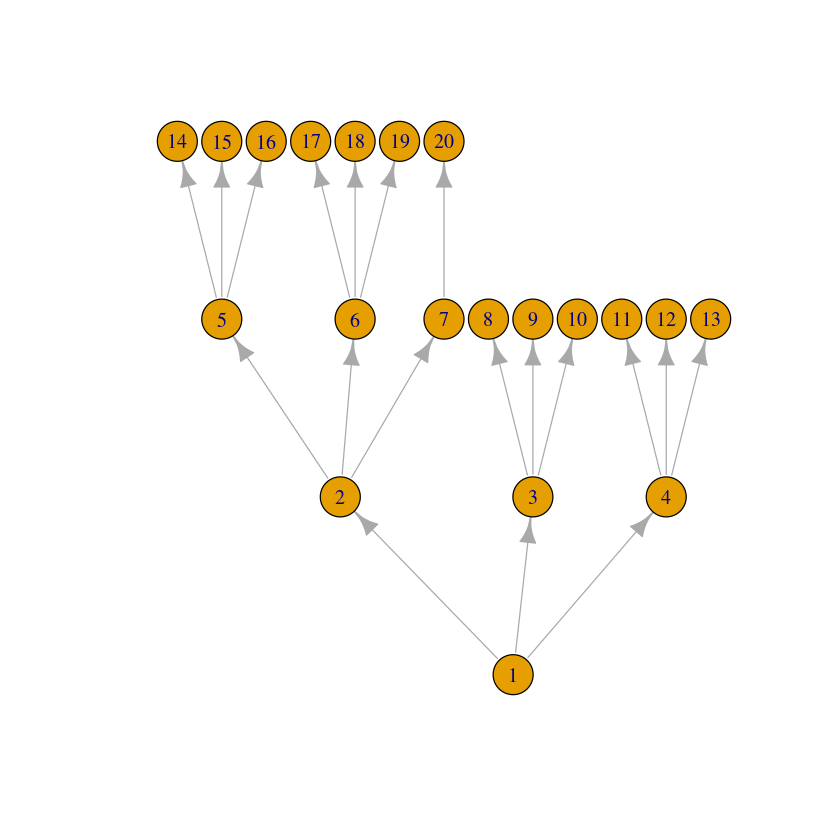

In [288]:
plot(tree, layout=layout_as_tree(tree, flip.y=FALSE))

In [291]:
tree

IGRAPH 5ce1f39 D--- 20 19 -- Tree
+ attr: name (g/c), children (g/n), mode (g/c)
+ edges from 5ce1f39:
 [1] 1-> 2 1-> 3 1-> 4 2-> 5 2-> 6 2-> 7 3-> 8 3-> 9 3->10 4->11 4->12 4->13
[13] 5->14 5->15 5->16 6->17 6->18 6->19 7->20

In [290]:
# make a graph from a dataframe
# https://igraph.org/r/doc/graph_from_data_frame.html

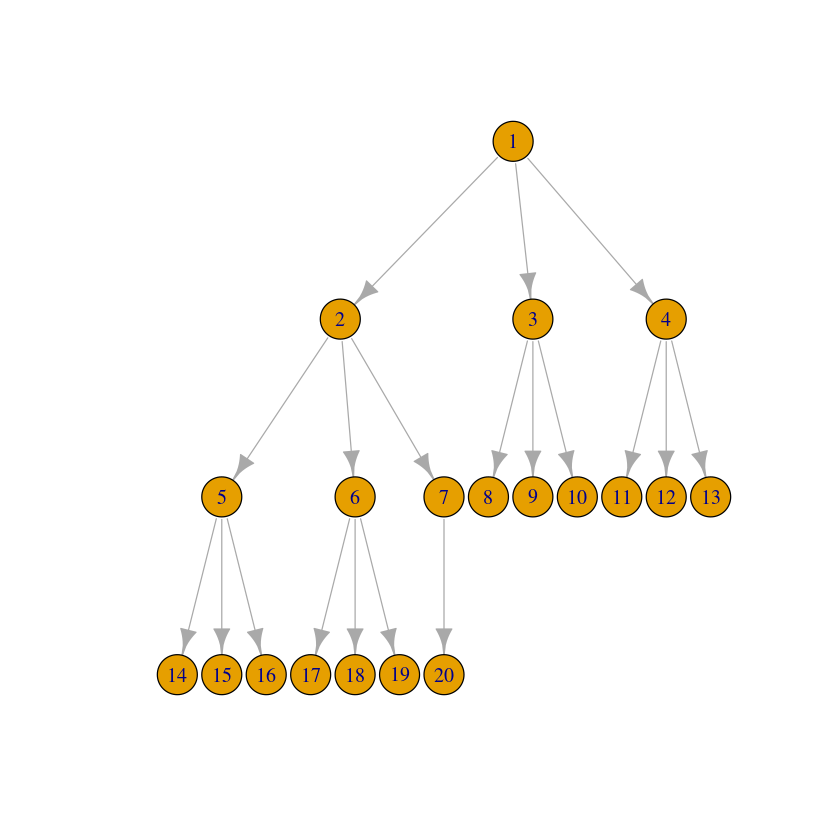

In [290]:
plot(tree, layout=layout_as_tree(tree, circular=FALSE))

In [ ]:
tree2 <- make_tree(10, 3) + make_tree(10, 2)
plot(tree2, layout=layout_as_tree)
plot(tree2, layout=layout_as_tree(tree2, root=c(1,11),
                                           rootlevel=c(2,1)))

In [294]:
#https://stackoverflow.com/questions/40646263/make-a-tree-in-r-with-parents 